<img style="float: center;" src='https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_header.png' alt="stsci_logo" width="900px"/> 

# MIRI Imaging Pipeline Notebook

**Authors**: M. Cracraft<br>
**Last Updated**: July 16, 2025<br>
**Pipeline Version**: 1.19.1 (Build 12.0)

**Purpose**:<br>
This notebook provides a framework for processing generic Mid-Infrared Instrument 
(MIRI) Imaging data through all
three James Webb Space Telescope (JWST) pipeline stages.  Data is assumed
to be located in one observation folder according to paths set up below.
It should not be necessary to edit any cells other than in the
[Configuration](#1.-Configuration) section unless modifying the standard
pipeline processing options.

**Data**:<br>
This example is set up to use an example dataset is from
[Program ID](https://www.stsci.edu/jwst/science-execution/program-information)
1040 (PI: O. Detre, Co-I: A. Noriega-Crespo) which is an external flat commissioning program.
The MIRI imaging dataset uses a 5-step dither pattern. Example input data to use will be
downloaded automatically unless disabled (i.e., to use local files instead).

**JWST pipeline version and CRDS context**:<br>
This notebook was written for the calibration pipeline version given above and uses the context associated with this version of the JWST Calibration Pipeline. Information about this an other contexts can be found in the JWST Calibration Reference Data System (CRDS) [server]((https://jwst-crds.stsci.edu/)). If you use different pipeline
versions, please refer to the table [here](https://jwst-crds.stsci.edu/display_build_contexts/) to determine what context to use. To learn more about the differences for the pipeline, read the relevant [documentation](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline/jwst-operations-pipeline-build-information)<br>

**Updates**:<br>
This notebook is regularly updated as improvements are made to the
pipeline. Find the most up to date version of this notebook at:
https://github.com/spacetelescope/jwst-pipeline-notebooks/

**Recent Changes**:<br>
September 25, 2024: original notebook released<br>
November 22, 2024: Updates to workflow when skipping pipeline modules<br>
January 16, 2025: Add handling for dedicated backgrounds, update to jwst 1.17.1<br>
May 5, 2025: Updated to jwst 1.18.0 (no significant changes)<br>
July 16, 2025: Updated to jwst 1.19.1 (no significant changes)

<hr style="border:1px solid gray"> </hr>

## Table of Contents
1. [Configuration](#1.-Configuration)
2. [Package Imports](#2.-Package-Imports)
3. [Demo Mode Setup (ignore if not using demo data)](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data))
4. [Directory Setup](#4.-Directory-Setup)
3. [Detector 1 Pipeline](#5.-Detector1-Pipeline)
4. [Image2 Pipeline](#6.-Image2-Pipeline)
5. [Image3 Pipeline](#7.-Image3-Pipeline)
6. [Visualize the data](#8.-Visualize-the-drizzle-combined-image)

<hr style="border:1px solid gray"> </hr>

## 1. Configuration
------------------
Set basic configuration for running notebook.

### Install dependencies and parameters

To make sure that the pipeline version is compatabile with the steps
discussed below and the required dependencies and packages are installed,
you can create a fresh conda environment and install the provided
`requirements.txt` file before starting this notebook: <br>
```
conda create -n miri_imaging_pipeline python=3.11
conda activate miri_imaging_pipeline
pip install -r requirements.txt
```

Set the basic parameters to use with this notebook. These will affect
what data is used, where data is located (if already in disk), and
pipeline modules run in this data. The list of parameters are:

* demo_mode
* directories with data
* pipeline modules

In [1]:
# Basic import necessary for configuration
import os

<div class="alert alert-block alert-warning">
Note that <code>demo_mode</code> must be set appropriately below.
</div>

Set <code>demo_mode = True </code> to run in demonstration mode. In this
mode this notebook will download example data from the Barbara A.
Mikulski Archive for Space Telescopes
([MAST](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html))
and process it through the pipeline. This will all happen in a local
directory unless modified in
[Section 3](#3.-Demo-Mode-Setup-(ignore-if-not-using-demo-data)) below.<br>

Set <code>demo_mode = False</code> if you want to process your own data
that has already been downloaded and provide the location of the data.<br>

In [2]:
# Set parameters for demo_mode and processing steps.

# -----------------------------Demo Mode---------------------------------
demo_mode = True

if demo_mode:
    print('Running in demonstration mode using online example data!')

# --------------------------User Mode Directories------------------------
# If demo_mode = False, look for user data in these paths
if not demo_mode:
    # Set directory paths for processing specific data; these will need
    # to be changed to your local directory setup (below are given as
    # examples)
    user_home_dir = os.path.expanduser('~')

    # Point to where science observation data are
    # Assumes uncalibrated data in sci_dir/uncal/ and results in stage1,
    # stage2, stage3 directories
    sci_dir = os.path.join(user_home_dir, 'FlightData/APT1040/data/Obs001/')
    
    # Point to where background observation data are
    # Assumes uncalibrated data in bg_dir/uncal/ and results in stage1 directory
    #bg_dir = os.path.join(user_home_dir, 'FlightData/APT1714/data/Obs02/')
    bg_dir = '' # If no background observation, use an empty string

# --------------------------Set Processing Steps--------------------------
# Individual pipeline stages can be turned on/off here.  Note that a later
# stage won't be able to run unless data products have already been
# produced from the prior stage.

# Science processing
dodet1 = True  # calwebb_detector1
doimage2 = True  # calwebb_image2
doimage3 = True  # calwebb_image3
doviz = True # Visualize calwebb_image3 results

# Background processing (if present)
dodet1bg = True  # calwebb_detector1

Running in demonstration mode using online example data!


### Set CRDS context and server
Before importing <code>CRDS</code> and <code>JWST</code> modules, we need
to configure our environment. This includes defining a CRDS cache
directory in which to keep the reference files that will be used by the
calibration pipeline.<br>

If the root directory for the local CRDS cache directory has not been set
already, it will be set to create one in the home directory.

In [3]:
# ------------------------Set CRDS context and paths----------------------
# Each version of the calibration pipeline is associated with a specific CRDS
# context file. The pipeline will select the appropriate context file behind
# the scenes while running. However, if you wish to override the default context
# file and run the pipeline with a different context, you can set that using
# the CRDS_CONTEXT environment variable. Here we show how this is done,
# although we leave the line commented out in order to use the default context.
# If you wish to specify a different context, uncomment the line below.
#%env CRDS_CONTEXT jwst_1293.pmap

# Check whether the local CRDS cache directory has been set.
# If not, set it to the user home directory
if (os.getenv('CRDS_PATH') is None):
    os.environ['CRDS_PATH'] = os.path.join(os.path.expanduser('~'), 'crds')

# Check whether the CRDS server URL has been set.  If not, set it.
if (os.getenv('CRDS_SERVER_URL') is None):
    os.environ['CRDS_SERVER_URL'] = 'https://jwst-crds.stsci.edu'

# Echo CRDS path in use
print(f"CRDS local filepath: {os.environ['CRDS_PATH']}")
print(f"CRDS file server: {os.environ['CRDS_SERVER_URL']}")

CRDS local filepath: /home/runner/crds
CRDS file server: https://jwst-crds.stsci.edu


<hr style="border:1px solid gray"> </hr>

## 2. Package Imports

In [4]:
# Use the entire available screen width for this notebook
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [5]:
# Basic system utilities for interacting with files
# ----------------------General Imports------------------------------------
import glob
import time
from pathlib import Path
#import urllib.request

# Numpy for doing calculations
import numpy as np

# To display full ouptut of cell, not just the last result
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# --------------------Astroquery Imports------------------------------
# ASCII files, and downloading demo files
from astroquery.mast import Observations

# ----------------Matplotlib for visualizing images-------------------
import matplotlib.pyplot as plt

# -------------------Astropy routines for visualizing detected sources----------
from astropy.table import Table
from astropy.io import fits

# ----------------------JWST calibration pipeline------------------------
import jwst
import crds

from jwst.pipeline import Detector1Pipeline
from jwst.pipeline import Image2Pipeline
from jwst.pipeline import Image3Pipeline

# JWST pipeline utilities
from jwst import datamodels
from jwst.datamodels import ImageModel
from jwst.associations import asn_from_list as afl  # Tools for creating association files
from jwst.associations.lib.rules_level2_base import DMSLevel2bBase  # Definition of a Lvl2 association file
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base  # Definition of a Lvl3 association file

# Echo pipeline version and CRDS context in use
print(f"JWST Calibration Pipeline Version: {jwst.__version__}")
print(f"Using CRDS Context: {crds.get_context_name('jwst')}")

Matplotlib is building the font cache; this may take a moment.


JWST Calibration Pipeline Version: 1.19.1


CRDS - INFO -  Calibration SW Found: jwst 1.19.1 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.19.1.dist-info)


Using CRDS Context: jwst_1413.pmap


In [6]:
# Start a timer to keep track of runtime
time0 = time.perf_counter()

<hr style="border:1px solid gray"> </hr>

## 3. Demo Mode Setup (ignore if not using demo data)
------------------
If running in demonstration mode, set up the program information to
retrieve the uncalibrated data automatically from MAST using
[astroquery](https://astroquery.readthedocs.io/en/latest/mast/mast.html).
MAST allows for flexibility of searching by the proposal ID and the
observation ID instead of just filenames.<br>

For illustrative purposes, we focus on data taken through the MIRI
[F770W filter](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-observing-modes/miri-imaging#MIRIImaging-MIRIFiltersImagingfilters)
and start with uncalibrated data products. The files are named
`jw01040001005_03103_0000n_miri_uncal.fits`, where *n* refers to the
dither step number which ranges from 1 - 5.

More information about the JWST file naming conventions can be found at:
https://jwst-pipeline.readthedocs.io/en/latest/jwst/data_products/file_naming.html

In [7]:
# Set up the program information and paths for demo program
if demo_mode:
    print('Running in demonstration mode and will download example data from MAST!')
    program = '01040'
    sci_observtn = "001"
    visit = "005"
    data_dir = os.path.join('.', 'mir_im_demo_data')
    download_dir = data_dir
    sci_dir = os.path.join(data_dir, 'Obs' + sci_observtn)
    uncal_dir = os.path.join(sci_dir, 'uncal')
    bg_dir = ''

    # Ensure filepaths for input data exist
    if not os.path.exists(uncal_dir):
        os.makedirs(uncal_dir)

    # Create directory if it does not exist
    if not os.path.isdir(data_dir):
        os.mkdir(data_dir)

Running in demonstration mode and will download example data from MAST!


Identify list of science (SCI) uncalibrated files associated with visits.
<div class="alert alert-block alert-warning">
Selects only filter <i>f770w</i> data
</div>

In [8]:
# Obtain a list of observation IDs for the specified demo program
if demo_mode:
    # Science data
    sci_obs_id_table = Observations.query_criteria(instrument_name=["MIRI/IMAGE"],
                                                   provenance_name=["CALJWST"],  # Executed observations
                                                   filters=['F770W'],  # Data for Specific Filter
                                                   obs_id=['jw' + program + '-o' + sci_observtn + '*']
                                                   )

In [9]:
# Turn the list of visits into a list of uncalibrated data files
if demo_mode:
    # Define types of files to select
    file_dict = {'uncal': {'product_type': 'SCIENCE',
                           'productSubGroupDescription': 'UNCAL',
                           'calib_level': [1]}}

    # Science files
    sci_files_to_download = []

    # Loop over visits identifying uncalibrated files that are associated
    # with them
    for exposure in (sci_obs_id_table):
        products = Observations.get_product_list(exposure)
        for filetype, query_dict in file_dict.items():
            filtered_products = Observations.filter_products(products, productType=query_dict['product_type'],
                                                             productSubGroupDescription=query_dict['productSubGroupDescription'],
                                                             calib_level=query_dict['calib_level'])
            sci_files_to_download.extend(filtered_products['dataURI'])

    # Download only the files in a single visit
    sci_files_to_download = [match for match in sci_files_to_download if ('jw' + program + sci_observtn + visit) in match]
    sci_files_to_download = sorted(sci_files_to_download)
    print(f"Science files selected for downloading: {len(sci_files_to_download)}")

Science files selected for downloading: 5


Download all the uncal files and place them into the appropriate
directories.<br>

<div class="alert alert-block alert-warning">
Warning: If this notebook is halted during this step the downloaded file
may be incomplete, and cause crashes later on!
</div>

In [10]:
if demo_mode:
    for filename in sci_files_to_download:
        sci_manifest = Observations.download_file(filename,
                                                  local_path=os.path.join(uncal_dir, Path(filename).name))

 [Done]


 [Done]


 [Done]


 [Done]


 [Done]


<hr style="border:1px solid gray"> </hr>

## 4. Directory Setup
---------------------
Set up detailed paths to input/output stages here.

In [11]:
# Define output subdirectories to keep science data products organized
uncal_dir = os.path.join(sci_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_dir = os.path.join(sci_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here
image2_dir = os.path.join(sci_dir, 'stage2')  # calwebb_spec2 pipeline outputs will go here
image3_dir = os.path.join(sci_dir, 'stage3')  # calwebb_spec3 pipeline outputs will go here

# Output subdirectories to keep background data products organized
uncal_bgdir = os.path.join(bg_dir, 'uncal')  # Uncalibrated pipeline inputs should be here
det1_bgdir = os.path.join(bg_dir, 'stage1')  # calwebb_detector1 pipeline outputs will go here

# We need to check that the desired output directories exist, and if not
# create them
if not os.path.exists(det1_dir):
    os.makedirs(det1_dir)
if not os.path.exists(image2_dir):
    os.makedirs(image2_dir)
if not os.path.exists(image3_dir):
    os.makedirs(image3_dir)
    
if ((bg_dir != '') & (not os.path.exists(det1_bgdir))):
    os.makedirs(det1_bgdir)

In [12]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")

Runtime so far: 17 seconds


<hr style="border:1px solid gray"> </hr>

## 5. Detector1 Pipeline
Run the datasets through the
[Detector1](https://jwst-docs.stsci.edu/jwst-science-calibration-pipeline-overview/stages-of-jwst-data-processing/calwebb_detector1)
stage of the pipeline to apply detector level calibrations and create a
countrate data product where slopes are fitted to the integration ramps.
These `*_rate.fits` products are 2D (nrows x ncols), averaged over all
integrations. 3D countrate data products (`*_rateints.fits`) are also
created (nintegrations x nrows x ncols) which have the fitted ramp slopes
for each integration.<br>

By default, all steps in the `Detector1` stage of the pipeline are run for
MIRI except: the `group_scale`, `ipc` and the `gain_scale` steps.<br>

MIRI performs a few pipeline steps in calwebb_detector1 that are not performed for other instruments.
The [emicorr](https://jwst-pipeline.readthedocs.io/en/latest/jwst/emicorr/index.html#emicorr-step) step corrects
for known noise patterns in MIRI data. For certain subarrays, these noise patterns are clearly imprinted on
the data in the `rate.fits` files.<br>

The [firstframe](https://jwst-pipeline.readthedocs.io/en/latest/jwst/firstframe/index.html#firstframe-step) step flags the first frame in each integration as bad, if the number of groups per integration is greater than 3.<br>

The [lastframe](https://jwst-pipeline.readthedocs.io/en/latest/jwst/lastframe/index.html#lastframe-step) step
flags the last frame in each integration as bad, if the number of groups per integration is greater than 2.<br>

The [reset](https://jwst-pipeline.readthedocs.io/en/latest/jwst/reset/index.html#reset-step) correction step
corrects for the reset anomaly effect. This effect is caused by the non-ideal behavior of the field effect
transistor (FET) upon resetting in the dark causing the initial frames in an integration to be offset
from their expected values.<br>

The [rscd](https://jwst-pipeline.readthedocs.io/en/latest/jwst/rscd/index.html#rscd-step) step reads a reference
file for each data file and determines how many frames at the start of a ramp should be flagged as bad. There are a
number of nonlinearities at the start of MIRI ramps, and the flagging allows the more linear portion of the ramp to
be used for jump detection and ramp fitting, without using the initial, non-linear portion of the ramp. The number
of groups flagged depend on filter and subarray.<br>

As of CRDS context `jwst_1201.pmap` and later, the
[jump](https://jwst-pipeline.readthedocs.io/en/latest/api/jwst.jump.JumpStep.html) step
of the `DETECTOR1` stage of the pipeline will remove residuals associated
with [showers](https://jwst-docs.stsci.edu/known-issues-with-jwst-data/shower-and-snowball-artifacts)
for the MIRI imaging mode, but only for data with filter F1500W and shorter. The default parameters for this correction,
where `find_showers` set to `True` turns on the shower
removal algorithm, are specified in the `pars-jumpstep` parameter
reference files. Users may wish to alter parameters to optimize removal of
shower residuals. Available parameters are discussed in the
[Detection and Flagging of Showers and Snowballs in JWST Technical Report (Regan 2023)](https://www.stsci.edu/files/live/sites/www/files/home/jwst/documentation/technical-documents/_documents/JWST-STScI-008545.pdf).

In [13]:
# Set up a dictionary to define how the Detector1 pipeline should be configured

# Boilerplate dictionary setup
det1dict = {}
det1dict['group_scale'], det1dict['dq_init'], det1dict['emicorr'] = {}, {}, {}
det1dict['saturation'], det1dict['firstframe'], det1dict['lastframe'] = {}, {}, {}
det1dict['reset'], det1dict['linearity'], det1dict['rscd'] = {}, {}, {}
det1dict['dark_current'], det1dict['refpix'], det1dict['jump'] = {}, {}, {}
det1dict['ramp_fit'], det1dict['gain_scale'] = {}, {}

# Overrides for whether or not certain steps should be skipped
# skipping the refpix step
#det1dict['refpix']['skip'] = True
#det1dict['jump']['find_showers'] = False # Turn off detection of cosmic ray showers

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#det1dict['dq_init']['override_mask'] = 'myfile.fits'  # Bad pixel mask
#det1dict['saturation']['override_saturation'] = 'myfile.fits'  # Saturation
#det1dict['reset']['override_reset'] = 'myfile.fits'  # Reset
#det1dict['linearity']['override_linearity'] = 'myfile.fits'  # Linearity
#det1dict['rscd']['override_rscd'] = 'myfile.fits'  # RSCD
#det1dict['dark_current']['override_dark'] = 'myfile.fits'  # Dark current subtraction
#det1dict['jump']['override_gain'] = 'myfile.fits'  # Gain used by jump step
#det1dict['ramp_fit']['override_gain'] = 'myfile.fits'  # Gain used by ramp fitting step
#det1dict['jump']['override_readnoise'] = 'myfile.fits'  # Read noise used by jump step
#det1dict['ramp_fit']['override_readnoise'] = 'myfile.fits'  # Read noise used by ramp fitting step

# Turn on multi-core processing (off by default).  Choose what fraction of cores to use (quarter, half, or all)
det1dict['jump']['maximum_cores'] = 'half'

# Alter parameters to optimize removal of shower residuals (example)
#det1dict['jump']['after_jump_flag_dn1'] = X  # A floating point value in units of DN
#det1dict['jump']['after_jump_flag_time1'] = x.x # A floating point value in units of seconds

### Calibrating Science Files
Look for input science files and run calwebb_detector1 pipeline using the call method.

In [14]:
uncal_files = sorted(glob.glob(os.path.join(uncal_dir, '*_uncal.fits')))
uncal_bgfiles = sorted(glob.glob(os.path.join(uncal_bgdir, '*_uncal.fits')))

print('Found ' + str(len(uncal_files)) + ' science input files')
print('Found ' + str(len(uncal_bgfiles)) + ' background input files')

Found 5 science input files
Found 0 background input files


Look at the first file to determine exposure parameters and practice using
JWST datamodels¶

In [15]:
if dodet1:
    # print file name
    print(uncal_files[0])

    # Open file as JWST datamodel
    examine = datamodels.open(uncal_files[0])

    # Print out exposure info
    print(f"Instrument: {examine.meta.instrument.name}")
    print(f"Filter: {examine.meta.instrument.filter}")
    print(f"Number of integrations: {examine.meta.exposure.nints}")
    print(f"Number of groups: {examine.meta.exposure.ngroups}")
    print(f"Readout pattern: {examine.meta.exposure.readpatt}")
    print(f"Dither position number: {examine.meta.dither.position_number}")
    print("\n")

./mir_im_demo_data/Obs001/uncal/jw01040001005_03103_00001_mirimage_uncal.fits


Instrument: MIRI
Filter: F770W
Number of integrations: 1
Number of groups: 6
Readout pattern: FASTR1
Dither position number: 1




From the above, we confirm that the demo data file is for the MIRI instrument
using the `F770W` filter in the [Filter Wheel](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-instrumentation/miri-filters-and-dispersers#gsc.tab=0). This observation uses
the MIRI [readout pattern](https://jwst-docs.stsci.edu/jwst-mid-infrared-instrument/miri-instrumentation/miri-detector-overview/miri-detector-readout-overview#gsc.tab=0) FASTR1,
6 groups per integration, and 1 integration per exposure. This data file
is the 1st dither position in this exposure sequence. For more information
about how JWST exposures are defined by up-the-ramp sampling, see the
[Understanding Exposure Times JDox article](https://jwst-docs.stsci.edu/understanding-exposure-times).<br>

This metadata will be the same for all exposures in this observation other
than the dither position number.

In [16]:
# Run Detector1 stage of pipeline, specifying:
# output directory to save *_rate.fits files
# save_results flag set to True so the rate files are saved

if dodet1:
    for uncal in uncal_files:
        rate_result = Detector1Pipeline.call(uncal, output_dir=det1_dir, steps=det1dict, save_results=True,)
else:
    print('Skipping Detector1 processing')

2025-11-10 16:13:47,033 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_datalvl_0002.rmap      694 bytes  (1 / 206 files) (0 / 754.6 K bytes)


2025-11-10 16:13:47,116 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_calver_0054.rmap    5.5 K bytes  (2 / 206 files) (694 / 754.6 K bytes)


2025-11-10 16:13:47,193 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_system_0053.imap        385 bytes  (3 / 206 files) (6.2 K / 754.6 K bytes)


2025-11-10 16:13:47,252 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavelengthrange_0024.rmap    1.4 K bytes  (4 / 206 files) (6.6 K / 754.6 K bytes)


2025-11-10 16:13:47,311 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_wavecorr_0005.rmap      884 bytes  (5 / 206 files) (8.0 K / 754.6 K bytes)


2025-11-10 16:13:47,476 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_superbias_0081.rmap   36.1 K bytes  (6 / 206 files) (8.8 K / 754.6 K bytes)


2025-11-10 16:13:47,533 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sirskernel_0002.rmap      704 bytes  (7 / 206 files) (44.9 K / 754.6 K bytes)


2025-11-10 16:13:47,688 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_sflat_0027.rmap   20.6 K bytes  (8 / 206 files) (45.6 K / 754.6 K bytes)


2025-11-10 16:13:47,810 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_saturation_0018.rmap    2.0 K bytes  (9 / 206 files) (66.2 K / 754.6 K bytes)


2025-11-10 16:13:47,891 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_refpix_0015.rmap    1.6 K bytes  (10 / 206 files) (68.2 K / 754.6 K bytes)


2025-11-10 16:13:47,939 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_readnoise_0025.rmap    2.6 K bytes  (11 / 206 files) (69.8 K / 754.6 K bytes)


2025-11-10 16:13:47,996 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pictureframe_0001.rmap      675 bytes  (12 / 206 files) (72.4 K / 754.6 K bytes)


2025-11-10 16:13:48,076 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_photom_0013.rmap      958 bytes  (13 / 206 files) (73.1 K / 754.6 K bytes)


2025-11-10 16:13:48,154 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pathloss_0008.rmap    1.2 K bytes  (14 / 206 files) (74.0 K / 754.6 K bytes)


2025-11-10 16:13:48,200 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-whitelightstep_0001.rmap      777 bytes  (15 / 206 files) (75.2 K / 754.6 K bytes)


2025-11-10 16:13:48,250 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-spec2pipeline_0013.rmap    2.1 K bytes  (16 / 206 files) (76.0 K / 754.6 K bytes)


2025-11-10 16:13:48,297 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-resamplespecstep_0002.rmap      709 bytes  (17 / 206 files) (78.1 K / 754.6 K bytes)


2025-11-10 16:13:48,372 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-refpixstep_0002.rmap      831 bytes  (18 / 206 files) (78.8 K / 754.6 K bytes)


2025-11-10 16:13:48,416 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-outlierdetectionstep_0005.rmap    1.1 K bytes  (19 / 206 files) (79.6 K / 754.6 K bytes)


2025-11-10 16:13:48,461 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-jumpstep_0005.rmap      810 bytes  (20 / 206 files) (80.8 K / 754.6 K bytes)


2025-11-10 16:13:48,546 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-image2pipeline_0008.rmap    1.0 K bytes  (21 / 206 files) (81.6 K / 754.6 K bytes)


2025-11-10 16:13:48,593 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-detector1pipeline_0003.rmap    1.1 K bytes  (22 / 206 files) (82.6 K / 754.6 K bytes)


2025-11-10 16:13:48,652 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkpipeline_0003.rmap      872 bytes  (23 / 206 files) (83.7 K / 754.6 K bytes)


2025-11-10 16:13:48,727 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_pars-darkcurrentstep_0003.rmap    1.8 K bytes  (24 / 206 files) (84.5 K / 754.6 K bytes)


2025-11-10 16:13:48,773 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ote_0030.rmap    1.3 K bytes  (25 / 206 files) (86.3 K / 754.6 K bytes)


2025-11-10 16:13:48,817 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msaoper_0016.rmap    1.5 K bytes  (26 / 206 files) (87.6 K / 754.6 K bytes)


2025-11-10 16:13:48,872 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_msa_0027.rmap    1.3 K bytes  (27 / 206 files) (89.1 K / 754.6 K bytes)


2025-11-10 16:13:48,921 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_mask_0043.rmap    3.5 K bytes  (28 / 206 files) (90.4 K / 754.6 K bytes)


2025-11-10 16:13:48,966 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_linearity_0017.rmap    1.6 K bytes  (29 / 206 files) (93.9 K / 754.6 K bytes)


2025-11-10 16:13:49,012 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ipc_0006.rmap      876 bytes  (30 / 206 files) (95.5 K / 754.6 K bytes)


2025-11-10 16:13:49,078 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifuslicer_0017.rmap    1.5 K bytes  (31 / 206 files) (96.4 K / 754.6 K bytes)


2025-11-10 16:13:49,131 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifupost_0019.rmap    1.5 K bytes  (32 / 206 files) (97.9 K / 754.6 K bytes)


2025-11-10 16:13:49,176 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_ifufore_0017.rmap    1.5 K bytes  (33 / 206 files) (99.4 K / 754.6 K bytes)


2025-11-10 16:13:49,223 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_gain_0023.rmap    1.8 K bytes  (34 / 206 files) (100.9 K / 754.6 K bytes)


2025-11-10 16:13:49,267 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fpa_0028.rmap    1.3 K bytes  (35 / 206 files) (102.7 K / 754.6 K bytes)


2025-11-10 16:13:49,321 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fore_0026.rmap    5.0 K bytes  (36 / 206 files) (103.9 K / 754.6 K bytes)


2025-11-10 16:13:49,371 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_flat_0015.rmap    3.8 K bytes  (37 / 206 files) (108.9 K / 754.6 K bytes)


2025-11-10 16:13:49,419 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_fflat_0027.rmap    7.2 K bytes  (38 / 206 files) (112.7 K / 754.6 K bytes)


2025-11-10 16:13:49,496 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_extract1d_0018.rmap    2.3 K bytes  (39 / 206 files) (119.9 K / 754.6 K bytes)


2025-11-10 16:13:49,542 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_disperser_0028.rmap    5.7 K bytes  (40 / 206 files) (122.2 K / 754.6 K bytes)


2025-11-10 16:13:49,587 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dflat_0007.rmap    1.1 K bytes  (41 / 206 files) (127.9 K / 754.6 K bytes)


2025-11-10 16:13:49,631 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_dark_0076.rmap   34.3 K bytes  (42 / 206 files) (129.0 K / 754.6 K bytes)


2025-11-10 16:13:49,686 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_cubepar_0015.rmap      966 bytes  (43 / 206 files) (163.4 K / 754.6 K bytes)


2025-11-10 16:13:49,733 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_collimator_0026.rmap    1.3 K bytes  (44 / 206 files) (164.3 K / 754.6 K bytes)


2025-11-10 16:13:49,791 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_camera_0026.rmap    1.3 K bytes  (45 / 206 files) (165.7 K / 754.6 K bytes)


2025-11-10 16:13:49,836 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_barshadow_0007.rmap    1.8 K bytes  (46 / 206 files) (166.9 K / 754.6 K bytes)


2025-11-10 16:13:49,885 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_area_0018.rmap    6.3 K bytes  (47 / 206 files) (168.7 K / 754.6 K bytes)


2025-11-10 16:13:49,930 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_apcorr_0009.rmap    5.6 K bytes  (48 / 206 files) (175.0 K / 754.6 K bytes)


2025-11-10 16:13:49,975 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nirspec_0406.imap     5.8 K bytes  (49 / 206 files) (180.6 K / 754.6 K bytes)


2025-11-10 16:13:50,023 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wfssbkg_0011.rmap    3.1 K bytes  (50 / 206 files) (186.4 K / 754.6 K bytes)


2025-11-10 16:13:50,068 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_wavelengthrange_0008.rmap      897 bytes  (51 / 206 files) (189.5 K / 754.6 K bytes)


2025-11-10 16:13:50,128 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trappars_0004.rmap      753 bytes  (52 / 206 files) (190.4 K / 754.6 K bytes)


2025-11-10 16:13:50,171 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_trapdensity_0005.rmap      705 bytes  (53 / 206 files) (191.2 K / 754.6 K bytes)


2025-11-10 16:13:50,215 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_throughput_0005.rmap    1.3 K bytes  (54 / 206 files) (191.9 K / 754.6 K bytes)


2025-11-10 16:13:50,260 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_superbias_0031.rmap    7.7 K bytes  (55 / 206 files) (193.1 K / 754.6 K bytes)


2025-11-10 16:13:50,318 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specwcs_0015.rmap    3.1 K bytes  (56 / 206 files) (200.8 K / 754.6 K bytes)


2025-11-10 16:13:50,361 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_specprofile_0008.rmap    2.4 K bytes  (57 / 206 files) (203.9 K / 754.6 K bytes)


2025-11-10 16:13:50,410 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_speckernel_0006.rmap    1.0 K bytes  (58 / 206 files) (206.3 K / 754.6 K bytes)


2025-11-10 16:13:50,454 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_sirskernel_0002.rmap      700 bytes  (59 / 206 files) (207.4 K / 754.6 K bytes)


2025-11-10 16:13:50,507 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_saturation_0015.rmap      829 bytes  (60 / 206 files) (208.1 K / 754.6 K bytes)


2025-11-10 16:13:50,614 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_readnoise_0011.rmap      987 bytes  (61 / 206 files) (208.9 K / 754.6 K bytes)


2025-11-10 16:13:50,660 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_photom_0036.rmap    1.3 K bytes  (62 / 206 files) (209.9 K / 754.6 K bytes)


2025-11-10 16:13:50,704 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_persat_0007.rmap      674 bytes  (63 / 206 files) (211.1 K / 754.6 K bytes)


2025-11-10 16:13:50,748 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pathloss_0003.rmap      758 bytes  (64 / 206 files) (211.8 K / 754.6 K bytes)


2025-11-10 16:13:50,794 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pastasoss_0004.rmap      818 bytes  (65 / 206 files) (212.6 K / 754.6 K bytes)


2025-11-10 16:13:50,845 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-undersamplecorrectionstep_0001.rmap      904 bytes  (66 / 206 files) (213.4 K / 754.6 K bytes)


2025-11-10 16:13:50,888 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-tweakregstep_0012.rmap    3.1 K bytes  (67 / 206 files) (214.3 K / 754.6 K bytes)


2025-11-10 16:13:50,940 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-spec2pipeline_0009.rmap    1.2 K bytes  (68 / 206 files) (217.4 K / 754.6 K bytes)


2025-11-10 16:13:50,985 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-sourcecatalogstep_0002.rmap    2.3 K bytes  (69 / 206 files) (218.6 K / 754.6 K bytes)


2025-11-10 16:13:51,036 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-resamplestep_0002.rmap      687 bytes  (70 / 206 files) (221.0 K / 754.6 K bytes)


2025-11-10 16:13:51,079 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-outlierdetectionstep_0004.rmap    2.7 K bytes  (71 / 206 files) (221.6 K / 754.6 K bytes)


2025-11-10 16:13:51,176 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-jumpstep_0007.rmap    6.4 K bytes  (72 / 206 files) (224.3 K / 754.6 K bytes)


2025-11-10 16:13:51,220 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-image2pipeline_0005.rmap    1.0 K bytes  (73 / 206 files) (230.7 K / 754.6 K bytes)


2025-11-10 16:13:51,276 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-detector1pipeline_0002.rmap    1.0 K bytes  (74 / 206 files) (231.7 K / 754.6 K bytes)


2025-11-10 16:13:51,320 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkpipeline_0002.rmap      868 bytes  (75 / 206 files) (232.7 K / 754.6 K bytes)


2025-11-10 16:13:51,365 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-darkcurrentstep_0001.rmap      591 bytes  (76 / 206 files) (233.6 K / 754.6 K bytes)


2025-11-10 16:13:51,409 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_pars-chargemigrationstep_0005.rmap    5.7 K bytes  (77 / 206 files) (234.2 K / 754.6 K bytes)


2025-11-10 16:13:51,458 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_nrm_0005.rmap      663 bytes  (78 / 206 files) (239.9 K / 754.6 K bytes)


2025-11-10 16:13:51,504 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_mask_0023.rmap    1.4 K bytes  (79 / 206 files) (240.5 K / 754.6 K bytes)


2025-11-10 16:13:51,549 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_linearity_0022.rmap      961 bytes  (80 / 206 files) (241.9 K / 754.6 K bytes)


2025-11-10 16:13:51,594 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_ipc_0007.rmap      651 bytes  (81 / 206 files) (242.9 K / 754.6 K bytes)


2025-11-10 16:13:51,640 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_gain_0011.rmap      797 bytes  (82 / 206 files) (243.5 K / 754.6 K bytes)


2025-11-10 16:13:51,683 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_flat_0023.rmap    5.9 K bytes  (83 / 206 files) (244.3 K / 754.6 K bytes)


2025-11-10 16:13:51,729 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_filteroffset_0010.rmap      853 bytes  (84 / 206 files) (250.2 K / 754.6 K bytes)


2025-11-10 16:13:51,782 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_extract1d_0007.rmap      905 bytes  (85 / 206 files) (251.1 K / 754.6 K bytes)


2025-11-10 16:13:51,824 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_drizpars_0004.rmap      519 bytes  (86 / 206 files) (252.0 K / 754.6 K bytes)


2025-11-10 16:13:51,871 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_distortion_0025.rmap    3.4 K bytes  (87 / 206 files) (252.5 K / 754.6 K bytes)


2025-11-10 16:13:51,914 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_dark_0035.rmap    7.8 K bytes  (88 / 206 files) (255.9 K / 754.6 K bytes)


2025-11-10 16:13:51,965 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_bkg_0005.rmap    3.1 K bytes  (89 / 206 files) (263.7 K / 754.6 K bytes)


2025-11-10 16:13:52,010 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_area_0014.rmap    2.7 K bytes  (90 / 206 files) (266.8 K / 754.6 K bytes)


2025-11-10 16:13:52,059 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_apcorr_0010.rmap    4.3 K bytes  (91 / 206 files) (269.5 K / 754.6 K bytes)


2025-11-10 16:13:52,103 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_abvegaoffset_0004.rmap    1.4 K bytes  (92 / 206 files) (273.8 K / 754.6 K bytes)


2025-11-10 16:13:52,149 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_niriss_0283.imap      5.8 K bytes  (93 / 206 files) (275.1 K / 754.6 K bytes)


2025-11-10 16:13:52,195 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wfssbkg_0004.rmap    7.2 K bytes  (94 / 206 files) (280.9 K / 754.6 K bytes)


2025-11-10 16:13:52,238 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_wavelengthrange_0011.rmap      996 bytes  (95 / 206 files) (288.1 K / 754.6 K bytes)


2025-11-10 16:13:52,298 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_tsophot_0003.rmap      896 bytes  (96 / 206 files) (289.1 K / 754.6 K bytes)


2025-11-10 16:13:52,342 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trappars_0003.rmap    1.6 K bytes  (97 / 206 files) (290.0 K / 754.6 K bytes)


2025-11-10 16:13:52,386 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_trapdensity_0003.rmap    1.6 K bytes  (98 / 206 files) (291.6 K / 754.6 K bytes)


2025-11-10 16:13:52,549 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_superbias_0020.rmap   19.6 K bytes  (99 / 206 files) (293.2 K / 754.6 K bytes)


2025-11-10 16:13:52,602 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_specwcs_0024.rmap    8.0 K bytes  (100 / 206 files) (312.8 K / 754.6 K bytes)


2025-11-10 16:13:52,647 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_sirskernel_0003.rmap      671 bytes  (101 / 206 files) (320.8 K / 754.6 K bytes)


2025-11-10 16:13:52,692 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_saturation_0011.rmap    2.8 K bytes  (102 / 206 files) (321.5 K / 754.6 K bytes)


2025-11-10 16:13:52,737 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_readnoise_0027.rmap   26.6 K bytes  (103 / 206 files) (324.3 K / 754.6 K bytes)


2025-11-10 16:13:52,792 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_psfmask_0008.rmap   28.4 K bytes  (104 / 206 files) (350.9 K / 754.6 K bytes)


2025-11-10 16:13:52,849 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_photom_0028.rmap    3.4 K bytes  (105 / 206 files) (379.2 K / 754.6 K bytes)


2025-11-10 16:13:52,891 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_persat_0005.rmap    1.6 K bytes  (106 / 206 files) (382.6 K / 754.6 K bytes)


2025-11-10 16:13:52,934 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-whitelightstep_0004.rmap    2.0 K bytes  (107 / 206 files) (384.2 K / 754.6 K bytes)


2025-11-10 16:13:52,980 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-tweakregstep_0003.rmap    4.5 K bytes  (108 / 206 files) (386.2 K / 754.6 K bytes)


2025-11-10 16:13:53,025 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-spec2pipeline_0009.rmap      984 bytes  (109 / 206 files) (390.6 K / 754.6 K bytes)


2025-11-10 16:13:53,072 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-sourcecatalogstep_0002.rmap    4.6 K bytes  (110 / 206 files) (391.6 K / 754.6 K bytes)


2025-11-10 16:13:53,122 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-resamplestep_0002.rmap      687 bytes  (111 / 206 files) (396.3 K / 754.6 K bytes)


2025-11-10 16:13:53,167 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-outlierdetectionstep_0003.rmap      940 bytes  (112 / 206 files) (397.0 K / 754.6 K bytes)


2025-11-10 16:13:53,212 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-jumpstep_0005.rmap      806 bytes  (113 / 206 files) (397.9 K / 754.6 K bytes)


2025-11-10 16:13:53,259 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-image2pipeline_0004.rmap    1.1 K bytes  (114 / 206 files) (398.7 K / 754.6 K bytes)


2025-11-10 16:13:53,303 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-detector1pipeline_0006.rmap    1.7 K bytes  (115 / 206 files) (399.8 K / 754.6 K bytes)


2025-11-10 16:13:53,357 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkpipeline_0002.rmap      868 bytes  (116 / 206 files) (401.6 K / 754.6 K bytes)


2025-11-10 16:13:53,404 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_pars-darkcurrentstep_0001.rmap      618 bytes  (117 / 206 files) (402.4 K / 754.6 K bytes)


2025-11-10 16:13:53,449 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_mask_0012.rmap    4.1 K bytes  (118 / 206 files) (403.1 K / 754.6 K bytes)


2025-11-10 16:13:53,494 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_linearity_0011.rmap    2.4 K bytes  (119 / 206 files) (407.2 K / 754.6 K bytes)


2025-11-10 16:13:53,538 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_ipc_0003.rmap    2.0 K bytes  (120 / 206 files) (409.6 K / 754.6 K bytes)


2025-11-10 16:13:53,582 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_gain_0016.rmap    2.1 K bytes  (121 / 206 files) (411.6 K / 754.6 K bytes)


2025-11-10 16:13:53,624 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_flat_0028.rmap   51.7 K bytes  (122 / 206 files) (413.7 K / 754.6 K bytes)


2025-11-10 16:13:53,684 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_filteroffset_0004.rmap    1.4 K bytes  (123 / 206 files) (465.4 K / 754.6 K bytes)


2025-11-10 16:13:53,729 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_extract1d_0005.rmap    1.2 K bytes  (124 / 206 files) (466.8 K / 754.6 K bytes)


2025-11-10 16:13:53,774 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_drizpars_0001.rmap      519 bytes  (125 / 206 files) (468.0 K / 754.6 K bytes)


2025-11-10 16:13:53,824 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_distortion_0033.rmap   53.4 K bytes  (126 / 206 files) (468.5 K / 754.6 K bytes)


2025-11-10 16:13:53,890 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_dark_0049.rmap   29.6 K bytes  (127 / 206 files) (521.9 K / 754.6 K bytes)


2025-11-10 16:13:53,946 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_bkg_0002.rmap    7.0 K bytes  (128 / 206 files) (551.5 K / 754.6 K bytes)


2025-11-10 16:13:53,991 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_area_0012.rmap   33.5 K bytes  (129 / 206 files) (558.4 K / 754.6 K bytes)


2025-11-10 16:13:54,044 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_apcorr_0008.rmap    4.3 K bytes  (130 / 206 files) (591.9 K / 754.6 K bytes)


2025-11-10 16:13:54,086 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_abvegaoffset_0003.rmap    1.3 K bytes  (131 / 206 files) (596.2 K / 754.6 K bytes)


2025-11-10 16:13:54,142 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_nircam_0326.imap      5.6 K bytes  (132 / 206 files) (597.5 K / 754.6 K bytes)


2025-11-10 16:13:54,189 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_wavelengthrange_0027.rmap      929 bytes  (133 / 206 files) (603.1 K / 754.6 K bytes)


2025-11-10 16:13:54,235 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_tsophot_0004.rmap      882 bytes  (134 / 206 files) (604.1 K / 754.6 K bytes)


2025-11-10 16:13:54,279 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_straymask_0009.rmap      987 bytes  (135 / 206 files) (604.9 K / 754.6 K bytes)


2025-11-10 16:13:54,326 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_specwcs_0044.rmap    5.9 K bytes  (136 / 206 files) (605.9 K / 754.6 K bytes)


2025-11-10 16:13:54,371 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_saturation_0015.rmap    1.2 K bytes  (137 / 206 files) (611.8 K / 754.6 K bytes)


2025-11-10 16:13:54,413 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_rscd_0008.rmap    1.0 K bytes  (138 / 206 files) (613.0 K / 754.6 K bytes)


2025-11-10 16:13:54,457 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_resol_0006.rmap      790 bytes  (139 / 206 files) (614.0 K / 754.6 K bytes)


2025-11-10 16:13:54,501 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_reset_0026.rmap    3.9 K bytes  (140 / 206 files) (614.8 K / 754.6 K bytes)


2025-11-10 16:13:54,548 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_regions_0035.rmap    4.4 K bytes  (141 / 206 files) (618.7 K / 754.6 K bytes)


2025-11-10 16:13:54,592 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_readnoise_0023.rmap    1.6 K bytes  (142 / 206 files) (623.0 K / 754.6 K bytes)


2025-11-10 16:13:54,636 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psfmask_0009.rmap    2.1 K bytes  (143 / 206 files) (624.7 K / 754.6 K bytes)


2025-11-10 16:13:54,692 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_psf_0007.rmap    2.5 K bytes  (144 / 206 files) (626.8 K / 754.6 K bytes)


2025-11-10 16:13:54,738 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_photom_0057.rmap    3.7 K bytes  (145 / 206 files) (629.3 K / 754.6 K bytes)


2025-11-10 16:13:54,781 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pathloss_0005.rmap      866 bytes  (146 / 206 files) (633.0 K / 754.6 K bytes)


2025-11-10 16:13:54,825 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-whitelightstep_0003.rmap      912 bytes  (147 / 206 files) (633.9 K / 754.6 K bytes)


2025-11-10 16:13:54,869 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-tweakregstep_0003.rmap    1.8 K bytes  (148 / 206 files) (634.8 K / 754.6 K bytes)


2025-11-10 16:13:54,915 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec3pipeline_0010.rmap      886 bytes  (149 / 206 files) (636.7 K / 754.6 K bytes)


2025-11-10 16:13:54,960 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-spec2pipeline_0013.rmap    1.4 K bytes  (150 / 206 files) (637.5 K / 754.6 K bytes)


2025-11-10 16:13:55,003 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-sourcecatalogstep_0003.rmap    1.9 K bytes  (151 / 206 files) (639.0 K / 754.6 K bytes)


2025-11-10 16:13:55,047 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplestep_0002.rmap      677 bytes  (152 / 206 files) (640.9 K / 754.6 K bytes)


2025-11-10 16:13:55,091 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-resamplespecstep_0002.rmap      706 bytes  (153 / 206 files) (641.5 K / 754.6 K bytes)


2025-11-10 16:13:55,133 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-outlierdetectionstep_0020.rmap    3.4 K bytes  (154 / 206 files) (642.2 K / 754.6 K bytes)


2025-11-10 16:13:55,179 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-jumpstep_0011.rmap    1.6 K bytes  (155 / 206 files) (645.6 K / 754.6 K bytes)


2025-11-10 16:13:55,222 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-image2pipeline_0010.rmap    1.1 K bytes  (156 / 206 files) (647.2 K / 754.6 K bytes)


2025-11-10 16:13:55,290 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-extract1dstep_0003.rmap      807 bytes  (157 / 206 files) (648.3 K / 754.6 K bytes)


2025-11-10 16:13:55,333 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-emicorrstep_0003.rmap      796 bytes  (158 / 206 files) (649.1 K / 754.6 K bytes)


2025-11-10 16:13:55,377 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-detector1pipeline_0010.rmap    1.6 K bytes  (159 / 206 files) (649.9 K / 754.6 K bytes)


2025-11-10 16:13:55,421 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkpipeline_0002.rmap      860 bytes  (160 / 206 files) (651.5 K / 754.6 K bytes)


2025-11-10 16:13:55,464 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_pars-darkcurrentstep_0002.rmap      683 bytes  (161 / 206 files) (652.3 K / 754.6 K bytes)


2025-11-10 16:13:55,511 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsxartcorr_0002.rmap    2.2 K bytes  (162 / 206 files) (653.0 K / 754.6 K bytes)


2025-11-10 16:13:55,555 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mrsptcorr_0005.rmap    2.0 K bytes  (163 / 206 files) (655.2 K / 754.6 K bytes)


2025-11-10 16:13:55,605 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_mask_0028.rmap    4.6 K bytes  (164 / 206 files) (657.1 K / 754.6 K bytes)


2025-11-10 16:13:55,666 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_linearity_0018.rmap    2.8 K bytes  (165 / 206 files) (661.8 K / 754.6 K bytes)


2025-11-10 16:13:55,712 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_ipc_0008.rmap      700 bytes  (166 / 206 files) (664.6 K / 754.6 K bytes)


2025-11-10 16:13:55,757 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_gain_0013.rmap    3.9 K bytes  (167 / 206 files) (665.3 K / 754.6 K bytes)


2025-11-10 16:13:55,802 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringefreq_0003.rmap    1.4 K bytes  (168 / 206 files) (669.2 K / 754.6 K bytes)


2025-11-10 16:13:55,846 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_fringe_0019.rmap    3.9 K bytes  (169 / 206 files) (670.7 K / 754.6 K bytes)


2025-11-10 16:13:55,889 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_flat_0067.rmap   15.7 K bytes  (170 / 206 files) (674.6 K / 754.6 K bytes)


2025-11-10 16:13:55,945 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_filteroffset_0026.rmap    2.1 K bytes  (171 / 206 files) (690.2 K / 754.6 K bytes)


2025-11-10 16:13:55,990 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_extract1d_0020.rmap    1.4 K bytes  (172 / 206 files) (692.3 K / 754.6 K bytes)


2025-11-10 16:13:56,034 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_emicorr_0004.rmap      663 bytes  (173 / 206 files) (693.7 K / 754.6 K bytes)


2025-11-10 16:13:56,083 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_drizpars_0002.rmap      511 bytes  (174 / 206 files) (694.4 K / 754.6 K bytes)


2025-11-10 16:13:56,155 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_distortion_0041.rmap    4.8 K bytes  (175 / 206 files) (694.9 K / 754.6 K bytes)


2025-11-10 16:13:56,197 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_dark_0037.rmap    4.4 K bytes  (176 / 206 files) (699.6 K / 754.6 K bytes)


2025-11-10 16:13:56,241 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_cubepar_0017.rmap      800 bytes  (177 / 206 files) (704.0 K / 754.6 K bytes)


2025-11-10 16:13:56,291 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_area_0015.rmap      866 bytes  (178 / 206 files) (704.8 K / 754.6 K bytes)


2025-11-10 16:13:56,335 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_apcorr_0020.rmap    5.0 K bytes  (179 / 206 files) (705.7 K / 754.6 K bytes)


2025-11-10 16:13:56,382 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_abvegaoffset_0003.rmap    1.3 K bytes  (180 / 206 files) (710.6 K / 754.6 K bytes)


2025-11-10 16:13:56,425 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_miri_0449.imap        5.8 K bytes  (181 / 206 files) (711.9 K / 754.6 K bytes)


2025-11-10 16:13:56,468 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trappars_0004.rmap      903 bytes  (182 / 206 files) (717.7 K / 754.6 K bytes)


2025-11-10 16:13:56,513 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_trapdensity_0006.rmap      930 bytes  (183 / 206 files) (718.6 K / 754.6 K bytes)


2025-11-10 16:13:56,556 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_superbias_0017.rmap    3.8 K bytes  (184 / 206 files) (719.6 K / 754.6 K bytes)


2025-11-10 16:13:56,602 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_saturation_0009.rmap      779 bytes  (185 / 206 files) (723.4 K / 754.6 K bytes)


2025-11-10 16:13:56,651 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_readnoise_0014.rmap    1.3 K bytes  (186 / 206 files) (724.1 K / 754.6 K bytes)


2025-11-10 16:13:56,694 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_photom_0014.rmap    1.1 K bytes  (187 / 206 files) (725.4 K / 754.6 K bytes)


2025-11-10 16:13:56,738 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_persat_0006.rmap      884 bytes  (188 / 206 files) (726.5 K / 754.6 K bytes)


2025-11-10 16:13:56,785 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-tweakregstep_0002.rmap      850 bytes  (189 / 206 files) (727.4 K / 754.6 K bytes)


2025-11-10 16:13:56,836 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-sourcecatalogstep_0001.rmap      636 bytes  (190 / 206 files) (728.2 K / 754.6 K bytes)


2025-11-10 16:13:56,880 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-outlierdetectionstep_0001.rmap      654 bytes  (191 / 206 files) (728.9 K / 754.6 K bytes)


2025-11-10 16:13:56,923 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-image2pipeline_0005.rmap      974 bytes  (192 / 206 files) (729.5 K / 754.6 K bytes)


2025-11-10 16:13:56,968 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-detector1pipeline_0002.rmap    1.0 K bytes  (193 / 206 files) (730.5 K / 754.6 K bytes)


2025-11-10 16:13:57,011 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_pars-darkpipeline_0002.rmap      856 bytes  (194 / 206 files) (731.5 K / 754.6 K bytes)


2025-11-10 16:13:57,055 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_mask_0023.rmap    1.1 K bytes  (195 / 206 files) (732.4 K / 754.6 K bytes)


2025-11-10 16:13:57,103 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_linearity_0015.rmap      925 bytes  (196 / 206 files) (733.5 K / 754.6 K bytes)


2025-11-10 16:13:57,145 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_ipc_0003.rmap       614 bytes  (197 / 206 files) (734.4 K / 754.6 K bytes)


2025-11-10 16:13:57,190 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_gain_0010.rmap      890 bytes  (198 / 206 files) (735.0 K / 754.6 K bytes)


2025-11-10 16:13:57,233 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_flat_0009.rmap    1.1 K bytes  (199 / 206 files) (735.9 K / 754.6 K bytes)


2025-11-10 16:13:57,277 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_distortion_0011.rmap    1.2 K bytes  (200 / 206 files) (737.0 K / 754.6 K bytes)


2025-11-10 16:13:57,321 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_dark_0017.rmap    4.3 K bytes  (201 / 206 files) (738.2 K / 754.6 K bytes)


2025-11-10 16:13:57,365 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_area_0010.rmap    1.2 K bytes  (202 / 206 files) (742.5 K / 754.6 K bytes)


2025-11-10 16:13:57,408 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_apcorr_0004.rmap    4.0 K bytes  (203 / 206 files) (743.7 K / 754.6 K bytes)


2025-11-10 16:13:57,450 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_abvegaoffset_0002.rmap    1.3 K bytes  (204 / 206 files) (747.7 K / 754.6 K bytes)


2025-11-10 16:13:57,493 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_fgs_0123.imap         5.1 K bytes  (205 / 206 files) (748.9 K / 754.6 K bytes)


2025-11-10 16:13:57,536 - CRDS - INFO -  Fetching  /home/runner/crds/mappings/jwst/jwst_1413.pmap               580 bytes  (206 / 206 files) (754.0 K / 754.6 K bytes)


2025-11-10 16:13:57,754 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-11-10 16:13:57,799 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 16:13:57,816 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf      936 bytes  (1 / 1 files) (0 / 936 bytes)


2025-11-10 16:13:57,863 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 16:13:57,873 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf    1.9 K bytes  (1 / 1 files) (0 / 1.9 K bytes)


2025-11-10 16:13:57,919 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf


2025-11-10 16:13:57,931 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf    1.7 K bytes  (1 / 1 files) (0 / 1.7 K bytes)


2025-11-10 16:13:57,977 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-11-10 16:13:57,996 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 16:13:57,996 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 16:13:57,997 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 16:13:57,998 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 16:13:57,999 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 16:13:58,001 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 16:13:58,002 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 16:13:58,003 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 16:13:58,004 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 16:13:58,005 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 16:13:58,005 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 16:13:58,007 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 16:13:58,007 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 16:13:58,008 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 16:13:58,009 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 16:13:58,010 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 16:13:58,012 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 16:13:58,013 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 16:13:58,014 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 16:13:58,015 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 16:13:58,149 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./mir_im_demo_data/Obs001/uncal/jw01040001005_03103_00001_mirimage_uncal.fits',).


2025-11-10 16:13:58,169 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: '

2025-11-10 16:13:58,189 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01040001005_03103_00001_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 16:13:58,192 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits    3.1 G bytes  (1 / 9 files) (0 / 3.3 G bytes)


2025-11-10 16:28:43,628 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf   17.1 K bytes  (2 / 9 files) (3.1 G / 3.3 G bytes)


2025-11-10 16:28:43,808 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits   12.7 M bytes  (3 / 9 files) (3.1 G / 3.3 G bytes)


2025-11-10 16:28:47,397 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits   25.4 M bytes  (4 / 9 files) (3.1 G / 3.3 G bytes)


2025-11-10 16:28:50,658 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits    4.3 M bytes  (5 / 9 files) (3.1 G / 3.3 G bytes)


2025-11-10 16:28:51,307 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits    4.2 M bytes  (6 / 9 files) (3.1 G / 3.3 G bytes)


2025-11-10 16:28:52,102 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits  173.3 M bytes  (7 / 9 files) (3.1 G / 3.3 G bytes)


2025-11-10 16:29:25,330 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits   37.4 K bytes  (8 / 9 files) (3.3 G / 3.3 G bytes)


2025-11-10 16:29:25,402 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits    8.5 M bytes  (9 / 9 files) (3.3 G / 3.3 G bytes)


2025-11-10 16:29:27,076 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits'.


2025-11-10 16:29:27,077 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.


2025-11-10 16:29:27,077 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits'.


2025-11-10 16:29:27,077 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-11-10 16:29:27,078 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-11-10 16:29:27,078 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 16:29:27,079 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-11-10 16:29:27,079 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits'.


2025-11-10 16:29:27,080 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-11-10 16:29:27,080 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-11-10 16:29:27,081 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 16:29:27,081 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 16:29:27,081 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 16:29:27,082 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 16:29:27,323 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:27,330 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 16:29:27,330 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 16:29:27,332 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 16:29:27,466 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:27,477 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-11-10 16:29:27,522 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:27,534 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:27,547 - CRDS - INFO -  Calibration SW Found: jwst 1.19.1 (/usr/share/miniconda/lib/python3.13/site-packages/jwst-1.19.1.dist-info)


2025-11-10 16:29:27,691 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 16:29:27,823 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:27,848 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf


2025-11-10 16:29:27,865 - jwst.emicorr.emicorr - INFO - Using reference file to get subarray case.


2025-11-10 16:29:27,866 - jwst.emicorr.emicorr - INFO - With configuration: Subarray=FULL, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-11-10 16:29:27,866 - jwst.emicorr.emicorr - INFO - Will correct data for the following 1 frequencies: 


2025-11-10 16:29:27,867 - jwst.emicorr.emicorr - INFO -    ['Hz10']


2025-11-10 16:29:27,867 - jwst.emicorr.emicorr - INFO - Running EMI fit with algorithm = 'joint'.


2025-11-10 16:29:33,840 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-11-10 16:29:33,977 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:33,990 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-11-10 16:29:33,990 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 16:29:34,013 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:34,022 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:34,042 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 16:29:34,089 - stcal.saturation.saturation - INFO - Detected 820 saturated pixels


2025-11-10 16:29:34,092 - stcal.saturation.saturation - INFO - Detected 76 A/D floor pixels


2025-11-10 16:29:34,096 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 16:29:34,238 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:34,239 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 16:29:34,387 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:34,406 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 16:29:34,553 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:34,572 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 16:29:34,710 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:34,727 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits


2025-11-10 16:29:34,780 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:34,789 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:34,835 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 16:29:34,986 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:34,998 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-11-10 16:29:35,023 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:35,033 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:35,118 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 16:29:35,247 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:35,259 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-11-10 16:29:35,302 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 16:29:35,305 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 16:29:35,443 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:35,455 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits


2025-11-10 16:29:35,993 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 16:29:35,994 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0


2025-11-10 16:29:35,994 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 16:29:36,778 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 16:29:36,944 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:36,945 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 16:29:37,095 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:37,096 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 16:29:37,237 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:37,244 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 16:29:37,245 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 16:29:37,263 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits


2025-11-10 16:29:37,265 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-11-10 16:29:37,311 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 16:29:37,311 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 16:29:39,376 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 16:29:39,392 - stcal.jump.jump - WARNING - Not enough differences for shower detections


2025-11-10 16:29:39,392 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 16:29:39,393 - stcal.jump.jump - INFO - Total elapsed time = 2.08158 sec


2025-11-10 16:29:39,402 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 2.157420


2025-11-10 16:29:39,404 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 16:29:39,538 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:39,539 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 16:29:39,668 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:39,704 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-11-10 16:29:39,704 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits


2025-11-10 16:29:39,728 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 16:29:39,729 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 16:29:39,749 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 16:29:39,754 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 16:29:39,755 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 16:29:40,140 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.3830606937408447


2025-11-10 16:29:40,187 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 16:29:40,334 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:40,361 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 16:29:40,362 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 16:29:40,364 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 16:29:40,513 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01040001005_03103_00001_mirimage_uncal.fits>,).


2025-11-10 16:29:40,534 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 16:29:40,535 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 16:29:40,537 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 16:29:40,603 - stpipe.Detector1Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00001_mirimage_rateints.fits


2025-11-10 16:29:40,604 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 16:29:40,606 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 16:29:40,671 - stpipe.Detector1Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00001_mirimage_rate.fits


2025-11-10 16:29:40,672 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 16:29:40,672 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 16:29:40,695 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 16:29:40,709 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 16:29:40,719 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf


2025-11-10 16:29:40,731 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-11-10 16:29:40,746 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 16:29:40,747 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 16:29:40,748 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 16:29:40,749 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 16:29:40,750 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 16:29:40,751 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 16:29:40,752 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 16:29:40,753 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 16:29:40,753 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 16:29:40,754 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 16:29:40,755 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 16:29:40,756 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 16:29:40,756 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 16:29:40,758 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 16:29:40,759 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 16:29:40,759 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 16:29:40,761 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 16:29:40,762 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 16:29:40,763 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 16:29:40,764 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 16:29:40,900 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./mir_im_demo_data/Obs001/uncal/jw01040001005_03103_00002_mirimage_uncal.fits',).


2025-11-10 16:29:40,921 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: '

2025-11-10 16:29:40,941 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01040001005_03103_00002_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 16:29:40,944 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits'.


2025-11-10 16:29:40,944 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.


2025-11-10 16:29:40,945 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits'.


2025-11-10 16:29:40,945 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-11-10 16:29:40,946 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-11-10 16:29:40,946 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 16:29:40,947 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-11-10 16:29:40,947 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits'.


2025-11-10 16:29:40,948 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-11-10 16:29:40,948 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-11-10 16:29:40,949 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 16:29:40,949 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 16:29:40,950 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 16:29:40,950 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 16:29:41,185 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:41,193 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 16:29:41,194 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 16:29:41,195 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 16:29:41,329 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:41,338 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-11-10 16:29:41,378 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:41,389 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:41,402 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 16:29:41,537 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:41,561 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf


2025-11-10 16:29:41,578 - jwst.emicorr.emicorr - INFO - Using reference file to get subarray case.


2025-11-10 16:29:41,578 - jwst.emicorr.emicorr - INFO - With configuration: Subarray=FULL, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-11-10 16:29:41,579 - jwst.emicorr.emicorr - INFO - Will correct data for the following 1 frequencies: 


2025-11-10 16:29:41,579 - jwst.emicorr.emicorr - INFO -    ['Hz10']


2025-11-10 16:29:41,580 - jwst.emicorr.emicorr - INFO - Running EMI fit with algorithm = 'joint'.


2025-11-10 16:29:47,503 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-11-10 16:29:47,642 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:47,652 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-11-10 16:29:47,652 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 16:29:47,673 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:47,683 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:47,697 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 16:29:47,739 - stcal.saturation.saturation - INFO - Detected 845 saturated pixels


2025-11-10 16:29:47,742 - stcal.saturation.saturation - INFO - Detected 80 A/D floor pixels


2025-11-10 16:29:47,745 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 16:29:47,888 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:47,889 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 16:29:48,033 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:48,056 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 16:29:48,197 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:48,216 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 16:29:48,361 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:48,371 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits


2025-11-10 16:29:48,421 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:48,430 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:48,474 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 16:29:48,612 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:48,621 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-11-10 16:29:48,644 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:48,653 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:48,735 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 16:29:48,880 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:48,889 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-11-10 16:29:48,930 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 16:29:48,932 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 16:29:49,082 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:49,091 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits


2025-11-10 16:29:49,606 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 16:29:49,607 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0


2025-11-10 16:29:49,607 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 16:29:50,385 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 16:29:50,538 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:50,539 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 16:29:50,682 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:50,683 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 16:29:50,829 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:50,836 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 16:29:50,837 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 16:29:50,851 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits


2025-11-10 16:29:50,853 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-11-10 16:29:50,897 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 16:29:50,898 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 16:29:51,766 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 16:29:51,780 - stcal.jump.jump - WARNING - Not enough differences for shower detections


2025-11-10 16:29:51,781 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 16:29:51,782 - stcal.jump.jump - INFO - Total elapsed time = 0.883933 sec


2025-11-10 16:29:51,791 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.954477


2025-11-10 16:29:51,793 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 16:29:51,937 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:51,937 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 16:29:52,085 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:52,111 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-11-10 16:29:52,112 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits


2025-11-10 16:29:52,136 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 16:29:52,137 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 16:29:52,157 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 16:29:52,162 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 16:29:52,163 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 16:29:52,548 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.3830986022949219


2025-11-10 16:29:52,587 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 16:29:52,721 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:52,741 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 16:29:52,741 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 16:29:52,744 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 16:29:52,875 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01040001005_03103_00002_mirimage_uncal.fits>,).


2025-11-10 16:29:52,897 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 16:29:52,897 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 16:29:52,899 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 16:29:52,966 - stpipe.Detector1Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00002_mirimage_rateints.fits


2025-11-10 16:29:52,966 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 16:29:52,968 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 16:29:53,034 - stpipe.Detector1Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00002_mirimage_rate.fits


2025-11-10 16:29:53,034 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 16:29:53,035 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 16:29:53,057 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 16:29:53,072 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 16:29:53,082 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf


2025-11-10 16:29:53,093 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-11-10 16:29:53,109 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 16:29:53,110 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 16:29:53,111 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 16:29:53,112 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 16:29:53,113 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 16:29:53,113 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 16:29:53,114 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 16:29:53,115 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 16:29:53,116 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 16:29:53,118 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 16:29:53,118 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 16:29:53,119 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 16:29:53,120 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 16:29:53,121 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 16:29:53,122 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 16:29:53,123 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 16:29:53,124 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 16:29:53,126 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 16:29:53,127 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 16:29:53,127 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 16:29:53,268 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./mir_im_demo_data/Obs001/uncal/jw01040001005_03103_00003_mirimage_uncal.fits',).


2025-11-10 16:29:53,289 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: '

2025-11-10 16:29:53,308 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01040001005_03103_00003_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 16:29:53,311 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits'.


2025-11-10 16:29:53,311 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.


2025-11-10 16:29:53,312 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits'.


2025-11-10 16:29:53,312 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-11-10 16:29:53,312 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-11-10 16:29:53,313 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 16:29:53,313 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-11-10 16:29:53,314 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits'.


2025-11-10 16:29:53,314 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-11-10 16:29:53,315 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-11-10 16:29:53,315 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 16:29:53,316 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 16:29:53,316 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 16:29:53,316 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 16:29:53,554 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:29:53,561 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 16:29:53,562 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 16:29:53,563 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 16:29:53,697 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:29:53,706 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-11-10 16:29:53,745 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:53,756 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:29:53,769 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 16:29:53,902 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:29:53,928 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf


2025-11-10 16:29:53,944 - jwst.emicorr.emicorr - INFO - Using reference file to get subarray case.


2025-11-10 16:29:53,945 - jwst.emicorr.emicorr - INFO - With configuration: Subarray=FULL, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-11-10 16:29:53,945 - jwst.emicorr.emicorr - INFO - Will correct data for the following 1 frequencies: 


2025-11-10 16:29:53,946 - jwst.emicorr.emicorr - INFO -    ['Hz10']


2025-11-10 16:29:53,947 - jwst.emicorr.emicorr - INFO - Running EMI fit with algorithm = 'joint'.


2025-11-10 16:29:59,951 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-11-10 16:30:00,102 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:00,112 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-11-10 16:30:00,112 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 16:30:00,134 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:00,144 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:00,159 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 16:30:00,203 - stcal.saturation.saturation - INFO - Detected 801 saturated pixels


2025-11-10 16:30:00,205 - stcal.saturation.saturation - INFO - Detected 59 A/D floor pixels


2025-11-10 16:30:00,209 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 16:30:00,363 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:00,364 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 16:30:00,510 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:00,540 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 16:30:00,680 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:00,700 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 16:30:00,843 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:00,852 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits


2025-11-10 16:30:00,902 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:00,912 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:00,958 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 16:30:01,105 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:01,115 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-11-10 16:30:01,138 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:01,148 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:01,235 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 16:30:01,389 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:01,398 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-11-10 16:30:01,441 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 16:30:01,444 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 16:30:01,603 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:01,613 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits


2025-11-10 16:30:02,162 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 16:30:02,163 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0


2025-11-10 16:30:02,163 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 16:30:02,948 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 16:30:03,106 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:03,107 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 16:30:03,246 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:03,247 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 16:30:03,400 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:03,408 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 16:30:03,409 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 16:30:03,423 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits


2025-11-10 16:30:03,426 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-11-10 16:30:03,470 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 16:30:03,470 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 16:30:04,345 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 16:30:04,357 - stcal.jump.jump - WARNING - Not enough differences for shower detections


2025-11-10 16:30:04,358 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 16:30:04,358 - stcal.jump.jump - INFO - Total elapsed time = 0.887706 sec


2025-11-10 16:30:04,367 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.958924


2025-11-10 16:30:04,370 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 16:30:04,514 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:04,514 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 16:30:04,671 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:04,696 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-11-10 16:30:04,697 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits


2025-11-10 16:30:04,722 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 16:30:04,722 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 16:30:04,743 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 16:30:04,748 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 16:30:04,749 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 16:30:05,137 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.3867678642272949


2025-11-10 16:30:05,177 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 16:30:05,314 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:05,335 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 16:30:05,336 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 16:30:05,338 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 16:30:05,482 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01040001005_03103_00003_mirimage_uncal.fits>,).


2025-11-10 16:30:05,503 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 16:30:05,504 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 16:30:05,506 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 16:30:05,572 - stpipe.Detector1Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00003_mirimage_rateints.fits


2025-11-10 16:30:05,573 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 16:30:05,576 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 16:30:05,643 - stpipe.Detector1Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00003_mirimage_rate.fits


2025-11-10 16:30:05,644 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 16:30:05,644 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 16:30:05,667 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 16:30:05,682 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 16:30:05,691 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf


2025-11-10 16:30:05,702 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-11-10 16:30:05,718 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 16:30:05,719 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 16:30:05,719 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 16:30:05,720 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 16:30:05,721 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 16:30:05,723 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 16:30:05,723 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 16:30:05,725 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 16:30:05,725 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 16:30:05,727 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 16:30:05,727 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 16:30:05,728 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 16:30:05,729 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 16:30:05,731 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 16:30:05,732 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 16:30:05,733 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 16:30:05,734 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 16:30:05,735 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 16:30:05,736 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 16:30:05,737 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 16:30:05,876 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./mir_im_demo_data/Obs001/uncal/jw01040001005_03103_00004_mirimage_uncal.fits',).


2025-11-10 16:30:05,896 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: '

2025-11-10 16:30:05,915 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01040001005_03103_00004_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 16:30:05,918 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits'.


2025-11-10 16:30:05,919 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.


2025-11-10 16:30:05,919 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits'.


2025-11-10 16:30:05,920 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-11-10 16:30:05,920 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-11-10 16:30:05,921 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 16:30:05,921 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-11-10 16:30:05,922 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits'.


2025-11-10 16:30:05,922 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-11-10 16:30:05,923 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-11-10 16:30:05,923 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 16:30:05,924 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 16:30:05,924 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 16:30:05,925 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 16:30:06,163 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:06,170 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 16:30:06,171 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 16:30:06,173 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 16:30:06,308 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:06,317 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-11-10 16:30:06,368 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:06,380 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:06,394 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 16:30:06,546 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:06,572 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf


2025-11-10 16:30:06,589 - jwst.emicorr.emicorr - INFO - Using reference file to get subarray case.


2025-11-10 16:30:06,589 - jwst.emicorr.emicorr - INFO - With configuration: Subarray=FULL, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-11-10 16:30:06,590 - jwst.emicorr.emicorr - INFO - Will correct data for the following 1 frequencies: 


2025-11-10 16:30:06,590 - jwst.emicorr.emicorr - INFO -    ['Hz10']


2025-11-10 16:30:06,591 - jwst.emicorr.emicorr - INFO - Running EMI fit with algorithm = 'joint'.


2025-11-10 16:30:12,580 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-11-10 16:30:12,727 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:12,737 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-11-10 16:30:12,738 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 16:30:12,759 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:12,768 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:12,782 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 16:30:12,824 - stcal.saturation.saturation - INFO - Detected 845 saturated pixels


2025-11-10 16:30:12,826 - stcal.saturation.saturation - INFO - Detected 60 A/D floor pixels


2025-11-10 16:30:12,830 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 16:30:12,970 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:12,971 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 16:30:13,101 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:13,126 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 16:30:13,264 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:13,283 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 16:30:13,426 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:13,435 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits


2025-11-10 16:30:13,485 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:13,495 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:13,546 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 16:30:13,681 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:13,691 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-11-10 16:30:13,714 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:13,723 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:13,811 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 16:30:13,952 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:13,961 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-11-10 16:30:14,002 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 16:30:14,004 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 16:30:14,145 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:14,155 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits


2025-11-10 16:30:14,682 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 16:30:14,682 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0


2025-11-10 16:30:14,683 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 16:30:15,467 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 16:30:15,615 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:15,616 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 16:30:15,754 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:15,755 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 16:30:15,887 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:15,895 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 16:30:15,896 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 16:30:15,909 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits


2025-11-10 16:30:15,911 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-11-10 16:30:15,956 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 16:30:15,956 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 16:30:16,892 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 16:30:16,907 - stcal.jump.jump - WARNING - Not enough differences for shower detections


2025-11-10 16:30:16,908 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 16:30:16,908 - stcal.jump.jump - INFO - Total elapsed time = 0.952108 sec


2025-11-10 16:30:16,918 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 1.022225


2025-11-10 16:30:16,920 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 16:30:17,076 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:17,077 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 16:30:17,227 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:17,255 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-11-10 16:30:17,255 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits


2025-11-10 16:30:17,280 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 16:30:17,280 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 16:30:17,304 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 16:30:17,309 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 16:30:17,310 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 16:30:17,707 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.3963348865509033


2025-11-10 16:30:17,747 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 16:30:17,886 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:17,914 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 16:30:17,915 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 16:30:17,918 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 16:30:18,077 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01040001005_03103_00004_mirimage_uncal.fits>,).


2025-11-10 16:30:18,099 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 16:30:18,100 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 16:30:18,102 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 16:30:18,183 - stpipe.Detector1Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00004_mirimage_rateints.fits


2025-11-10 16:30:18,184 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 16:30:18,186 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 16:30:18,251 - stpipe.Detector1Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00004_mirimage_rate.fits


2025-11-10 16:30:18,252 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 16:30:18,253 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 16:30:18,275 - stpipe - INFO - PARS-EMICORRSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-emicorrstep_0003.asdf


2025-11-10 16:30:18,289 - stpipe - INFO - PARS-DARKCURRENTSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-darkcurrentstep_0001.asdf


2025-11-10 16:30:18,299 - stpipe - INFO - PARS-JUMPSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-jumpstep_0005.asdf


2025-11-10 16:30:18,310 - stpipe - INFO - PARS-DETECTOR1PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-detector1pipeline_0008.asdf


2025-11-10 16:30:18,326 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2025-11-10 16:30:18,326 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2025-11-10 16:30:18,327 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2025-11-10 16:30:18,328 - stpipe.Detector1Pipeline.emicorr - INFO - EmiCorrStep instance created.


2025-11-10 16:30:18,329 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2025-11-10 16:30:18,330 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2025-11-10 16:30:18,331 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2025-11-10 16:30:18,332 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2025-11-10 16:30:18,332 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2025-11-10 16:30:18,334 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2025-11-10 16:30:18,335 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2025-11-10 16:30:18,336 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2025-11-10 16:30:18,337 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2025-11-10 16:30:18,338 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2025-11-10 16:30:18,339 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2025-11-10 16:30:18,340 - stpipe.Detector1Pipeline.charge_migration - INFO - ChargeMigrationStep instance created.


2025-11-10 16:30:18,342 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2025-11-10 16:30:18,343 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - CleanFlickerNoiseStep instance created.


2025-11-10 16:30:18,344 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2025-11-10 16:30:18,345 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2025-11-10 16:30:18,486 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('./mir_im_demo_data/Obs001/uncal/jw01040001005_03103_00005_mirimage_uncal.fits',).


2025-11-10 16:30:18,506 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage1
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_calibrated_ramp: False
  steps:
    group_scale:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
    dq_init:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: '

2025-11-10 16:30:18,526 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'jw01040001005_03103_00005_mirimage_uncal.fits' reftypes = ['dark', 'emicorr', 'gain', 'linearity', 'mask', 'persat', 'readnoise', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2025-11-10 16:30:18,529 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits'.


2025-11-10 16:30:18,530 - stpipe.Detector1Pipeline - INFO - Prefetch for EMICORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf'.


2025-11-10 16:30:18,530 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits'.


2025-11-10 16:30:18,530 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits'.


2025-11-10 16:30:18,531 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits'.


2025-11-10 16:30:18,531 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2025-11-10 16:30:18,532 - stpipe.Detector1Pipeline - INFO - Prefetch for READNOISE reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits'.


2025-11-10 16:30:18,532 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits'.


2025-11-10 16:30:18,532 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits'.


2025-11-10 16:30:18,533 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits'.


2025-11-10 16:30:18,534 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2025-11-10 16:30:18,534 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2025-11-10 16:30:18,535 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2025-11-10 16:30:18,535 - jwst.pipeline.calwebb_detector1 - INFO - Starting calwebb_detector1 ...


2025-11-10 16:30:18,768 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:18,776 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES and FRMDIVSR are equal; correction not needed


2025-11-10 16:30:18,776 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2025-11-10 16:30:18,778 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2025-11-10 16:30:18,912 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:18,921 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /home/runner/crds/references/jwst/miri/jwst_miri_mask_0036.fits


2025-11-10 16:30:18,960 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:18,971 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:18,983 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2025-11-10 16:30:19,120 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:19,140 - stpipe.Detector1Pipeline.emicorr - INFO - Using CRDS reference file: /home/runner/crds/references/jwst/miri/jwst_miri_emicorr_0003.asdf


2025-11-10 16:30:19,156 - jwst.emicorr.emicorr - INFO - Using reference file to get subarray case.


2025-11-10 16:30:19,157 - jwst.emicorr.emicorr - INFO - With configuration: Subarray=FULL, Read_pattern=FASTR1, Detector=MIRIMAGE


2025-11-10 16:30:19,157 - jwst.emicorr.emicorr - INFO - Will correct data for the following 1 frequencies: 


2025-11-10 16:30:19,158 - jwst.emicorr.emicorr - INFO -    ['Hz10']


2025-11-10 16:30:19,159 - jwst.emicorr.emicorr - INFO - Running EMI fit with algorithm = 'joint'.


2025-11-10 16:30:25,102 - stpipe.Detector1Pipeline.emicorr - INFO - Step emicorr done


2025-11-10 16:30:25,237 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:25,248 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /home/runner/crds/references/jwst/miri/jwst_miri_saturation_0034.fits


2025-11-10 16:30:25,248 - stpipe.Detector1Pipeline.saturation - INFO - Using SUPERBIAS reference file N/A


2025-11-10 16:30:25,269 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:25,278 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:25,295 - jwst.saturation.saturation - INFO - Using read_pattern with nframes 1


2025-11-10 16:30:25,337 - stcal.saturation.saturation - INFO - Detected 826 saturated pixels


2025-11-10 16:30:25,340 - stcal.saturation.saturation - INFO - Detected 59 A/D floor pixels


2025-11-10 16:30:25,344 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2025-11-10 16:30:25,486 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:25,486 - stpipe.Detector1Pipeline.ipc - INFO - Step skipped.


2025-11-10 16:30:25,633 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:25,652 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2025-11-10 16:30:25,785 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:25,809 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2025-11-10 16:30:25,952 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:25,960 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /home/runner/crds/references/jwst/miri/jwst_miri_reset_0077.fits


2025-11-10 16:30:26,009 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:26,019 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:26,058 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2025-11-10 16:30:26,192 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:26,202 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /home/runner/crds/references/jwst/miri/jwst_miri_linearity_0032.fits


2025-11-10 16:30:26,224 - stdatamodels.dynamicdq - WARNING - Keyword RESERVED_4 does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:26,233 - stdatamodels.dynamicdq - WARNING - Keyword UNRELIABLE_RESET does not correspond to an existing DQ mnemonic, so will be ignored


2025-11-10 16:30:26,315 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2025-11-10 16:30:26,460 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:26,469 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /home/runner/crds/references/jwst/miri/jwst_miri_rscd_0017.fits


2025-11-10 16:30:26,510 - jwst.rscd.rscd_sub - INFO - Number of groups to skip for integrations 2 and higher: 2


2025-11-10 16:30:26,513 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2025-11-10 16:30:26,660 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:26,670 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /home/runner/crds/references/jwst/miri/jwst_miri_dark_0113.fits


2025-11-10 16:30:27,182 - stpipe.Detector1Pipeline.dark_current - INFO - Using Poisson noise from average dark current 1.0 e-/sec


2025-11-10 16:30:27,183 - stcal.dark_current.dark_sub - INFO - Science data nints=1, ngroups=6, nframes=1, groupgap=0


2025-11-10 16:30:27,183 - stcal.dark_current.dark_sub - INFO - Dark data nints=2, ngroups=360, nframes=1, groupgap=0


2025-11-10 16:30:27,965 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2025-11-10 16:30:28,116 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:28,117 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2025-11-10 16:30:28,252 - stpipe.Detector1Pipeline.charge_migration - INFO - Step charge_migration running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:28,252 - stpipe.Detector1Pipeline.charge_migration - INFO - Step skipped.


2025-11-10 16:30:28,385 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:28,392 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 4 sigma


2025-11-10 16:30:28,392 - stpipe.Detector1Pipeline.jump - INFO - Maximum cores to use = half


2025-11-10 16:30:28,406 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits


2025-11-10 16:30:28,408 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-11-10 16:30:28,453 - stcal.jump.jump - INFO - Executing two-point difference method


2025-11-10 16:30:28,454 - stcal.jump.jump - INFO - Creating 2 processes for jump detection 


2025-11-10 16:30:29,332 - stcal.jump.jump - INFO - Flagging Showers


2025-11-10 16:30:29,345 - stcal.jump.jump - WARNING - Not enough differences for shower detections


2025-11-10 16:30:29,345 - stcal.jump.jump - INFO - Total showers= 0


2025-11-10 16:30:29,346 - stcal.jump.jump - INFO - Total elapsed time = 0.892013 sec


2025-11-10 16:30:29,355 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 0.963223


2025-11-10 16:30:29,357 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2025-11-10 16:30:29,514 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step clean_flicker_noise running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:29,516 - stpipe.Detector1Pipeline.clean_flicker_noise - INFO - Step skipped.


2025-11-10 16:30:29,671 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(1, 6, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:29,693 - jwst.ramp_fitting.ramp_fit_step - INFO - Using READNOISE reference file: /home/runner/crds/references/jwst/miri/jwst_miri_readnoise_0085.fits


2025-11-10 16:30:29,694 - jwst.ramp_fitting.ramp_fit_step - INFO - Using GAIN reference file: /home/runner/crds/references/jwst/miri/jwst_miri_gain_0034.fits


2025-11-10 16:30:29,719 - jwst.ramp_fitting.ramp_fit_step - INFO - Using algorithm = OLS_C


2025-11-10 16:30:29,719 - jwst.ramp_fitting.ramp_fit_step - INFO - Using weighting = optimal


2025-11-10 16:30:29,741 - stcal.ramp_fitting.ols_fit - INFO - Number of multiprocessing slices: 1


2025-11-10 16:30:29,746 - stcal.ramp_fitting.ols_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2025-11-10 16:30:29,746 - stcal.ramp_fitting.ols_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2025-11-10 16:30:30,144 - stcal.ramp_fitting.ols_fit - INFO - Ramp Fitting C Time: 0.3961353302001953


2025-11-10 16:30:30,184 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2025-11-10 16:30:30,327 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:30,348 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 16:30:30,348 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 16:30:30,350 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 16:30:30,489 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(1, 1024, 1032) from jw01040001005_03103_00005_mirimage_uncal.fits>,).


2025-11-10 16:30:30,510 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2025-11-10 16:30:30,510 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2025-11-10 16:30:30,512 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2025-11-10 16:30:30,577 - stpipe.Detector1Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00005_mirimage_rateints.fits


2025-11-10 16:30:30,578 - jwst.pipeline.calwebb_detector1 - INFO - ... ending calwebb_detector1


2025-11-10 16:30:30,579 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 16:30:30,644 - stpipe.Detector1Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00005_mirimage_rate.fits


2025-11-10 16:30:30,645 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2025-11-10 16:30:30,645 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


### Calibrating Background Files
Look for input background files and run calwebb_detector1
pipeline using the call method.

In [17]:
# Run Detector1 stage of pipeline on any background files

if dodet1bg:
    for uncal in uncal_bgfiles:
        rate_result = Detector1Pipeline.call(uncal, output_dir=det1_bgdir, steps=det1dict, save_results=True,)
else:
    print('Skipping Detector1 BG processing')

In [18]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime for Detector1: {time1 - time0:0.0f} seconds")

Runtime for Detector1: 1023 seconds


### Exploring the data

Identify `*_rate.fits` files and verify which pipeline steps were run and
which calibration reference files were applied.<br>

The header contains information about which calibration steps were
completed and skipped and which reference files were used to process the
data.<br>

In [19]:
if dodet1:
    # find rate files
    rate_files = sorted(glob.glob(os.path.join(det1_dir, '*_rate.fits')))

    # Read in file as datamodel
    rate_f = datamodels.open(rate_files[0])

    # Check which steps were run
    rate_f.meta.cal_step.instance

    # Check which reference files were used to calibrate the dataset:
    rate_f.meta.ref_file.instance

{'charge_migration': 'SKIPPED',
 'clean_flicker_noise': 'SKIPPED',
 'dark_sub': 'COMPLETE',
 'dq_init': 'COMPLETE',
 'emicorr': 'COMPLETE',
 'firstframe': 'COMPLETE',
 'gain_scale': 'SKIPPED',
 'group_scale': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'lastframe': 'COMPLETE',
 'linearity': 'COMPLETE',
 'ramp_fit': 'COMPLETE',
 'refpix': 'SKIPPED',
 'reset': 'COMPLETE',
 'rscd': 'COMPLETE',
 'saturation': 'COMPLETE'}

{'crds': {'context_used': 'jwst_1413.pmap', 'sw_version': '13.0.6'},
 'dark': {'name': 'crds://jwst_miri_dark_0113.fits'},
 'emicorr': {'name': 'crds://jwst_miri_emicorr_0003.asdf'},
 'gain': {'name': 'crds://jwst_miri_gain_0034.fits'},
 'linearity': {'name': 'crds://jwst_miri_linearity_0032.fits'},
 'mask': {'name': 'crds://jwst_miri_mask_0036.fits'},
 'readnoise': {'name': 'crds://jwst_miri_readnoise_0085.fits'},
 'reset': {'name': 'crds://jwst_miri_reset_0077.fits'},
 'rscd': {'name': 'crds://jwst_miri_rscd_0017.fits'},
 'saturation': {'name': 'crds://jwst_miri_saturation_0034.fits'},
 'superbias': {'name': 'N/A'}}

<hr style="border:1px solid gray"> </hr>

## 6. Image2 Pipeline 

In the [Image2](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image2.html) stage of the pipeline,
calibrated unrectified data products are created (`*_cal.fits` or
`*_calints.fits` files, depending on whether the input files are
`*_rate.fits` or `*_rateints.fits`). 

In this pipeline processing stage, the
[background subtraction](https://jwst-pipeline.readthedocs.io/en/latest/jwst/background_step/index.html#background-step)
step is performed if the data have a dedicated background defined,
the [world coordinate system (WCS)](https://jwst-pipeline.readthedocs.io/en/latest/jwst/assign_wcs/index.html#assign-wcs-step)
is assigned, the data are [flat fielded](https://jwst-pipeline.readthedocs.io/en/latest/jwst/flatfield/index.html#flatfield-step),
and a [photometric calibration](https://jwst-pipeline.readthedocs.io/en/latest/jwst/photom/index.html#photom-step)
is applied to convert from units of countrate (ADU/s) to surface brightness (MJy/sr).

The [resampling](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/index.html#resample-step)
step is performed, to create resampled images of each dither position, but this is
only a quick-look product. The resampling step occurs during the `Image3` stage by
default. While the resampling step is done in the `Image2` stage, the data quality
from the `Image3` stage will be better since the bad pixels, which adversely affect
both the centroids and photometry in individual images, will be mostly
removed.

In [20]:
time_image2 = time.perf_counter()

In [21]:
# Set up a dictionary to define how the Image2 pipeline should be configured.

# Boilerplate dictionary setup
image2dict = {}
image2dict['bkg_subtract'] = {}
image2dict['assign_wcs'], image2dict['flat_field'] = {}, {}
image2dict['photom'], image2dict['resample'] = {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#image2dict['resample']['skip'] = False

# Change the nsigma used for clipping the input background data
image2dict['bkg_subtract']['sigma'] = 2

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#image2dict['assign_wcs']['override_distortion'] = 'myfile.asdf'  # Spatial distortion (ASDF file)
#image2dict['assign_wcs']['override_filteroffset'] = 'myfile.asdf'  # Imager filter offsets (ASDF file)
#image2dict['assign_wcs']['override_specwcs'] = 'myfile.asdf'  # Spectral distortion (ASDF file)
#image2dict['assign_wcs']['override_wavelengthrange'] = 'myfile.asdf'  # Wavelength channel mapping (ASDF file)
#image2dict['flat_field']['override_flat'] = 'myfile.fits'  # Pixel flatfield
#image2dict['photom']['override_photom'] = 'myfile.fits'  # Photometric calibration array

Define a function to create association files for Stage 2. This will enable use of the pixel-based background subtraction, if chosen above. This requires *one* input SCI file, but can have multiple input background files.

<div class="alert alert-block alert-warning">
Note that the background will not be applied properly to all files if more than *one* SCI file is included in the association.
</div>

In [22]:
def writel2asn(onescifile, bgfiles, asnfile, prodname):
    # Define the basic association of science files
    asn = afl.asn_from_list([onescifile], rule=DMSLevel2bBase, product_name=prodname)  # Wrap in array since input was single exposure

    # Filter configuration for this sci file
    with fits.open(onescifile) as hdu:
        hdu.verify()
        hdr = hdu[0].header
        this_filter = hdr['FILTER']

    # If backgrounds were provided, find which are appropriate to this
    # filter and add to association
    for file in bgfiles:
        with fits.open(file) as hdu:
            hdu.verify()
            if (hdu[0].header['FILTER'] == this_filter):
                asn['products'][0]['members'].append({'expname': file, 'exptype': 'background'})              

    # Write the association to a json file
    _, serialized = asn.dump()
    with open(asnfile, 'w') as outfile:
        outfile.write(serialized)

Find and sort all of the input files, ensuring use of absolute paths

In [23]:
# Find all Science rate.fits files
sstring = os.path.join(det1_dir, 'jw*rate.fits')  # Use files from the detector1 output folder
rate_files = sorted(glob.glob(sstring))
for ii in range(0, len(rate_files)):
    rate_files[ii] = os.path.abspath(rate_files[ii])
rate_files = np.array(rate_files)

# Background Files
sstring = os.path.join(det1_bgdir, 'jw*rate.fits')
bgfiles = sorted(glob.glob(sstring))
for ii in range(0, len(bgfiles)):
    bgfiles[ii] = os.path.abspath(bgfiles[ii])
bgfiles = np.array(bgfiles)

print(f"Found  {str(len(rate_files))} science files")
print(f"Found  {str(len(bgfiles))} background files")

Found  5 science files
Found  0 background files


In [24]:
# Run Image2 stage of pipeline, specifying the output directory to save *_cal.fits files
# and save_results flag set to True so the rate files are saved
if doimage2:
    for rate in rate_files:
        asnfile = os.path.join(sci_dir, 'l2asn.json')
        writel2asn(rate, bgfiles, asnfile, 'Level2')
        cal_result = Image2Pipeline.call(asnfile, output_dir=image2_dir, steps=image2dict, save_results=True)
else:
    print("Skipping Image2 processing.")

2025-11-10 16:30:30,783 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-11-10 16:30:30,866 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-11-10 16:30:30,874 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0004.asdf    1.2 K bytes  (1 / 1 files) (0 / 1.2 K bytes)


2025-11-10 16:30:30,923 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0004.asdf


2025-11-10 16:30:30,934 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-11-10 16:30:30,935 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 16:30:30,936 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 16:30:30,937 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 16:30:30,938 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 16:30:30,939 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-11-10 16:30:31,074 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./mir_im_demo_data/Obs001/l2asn.json',).


2025-11-10 16:30:31,082 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      bkg_list: None
      save_combined_background: False
      sigma: 2
      maxiters: None
      soss_source_percentile: 35.0
      soss_bkg_percentile: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
     

2025-11-10 16:30:31,125 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'bkg', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']


2025-11-10 16:30:31,128 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits    4.2 M bytes  (1 / 5 files) (0 / 17.0 M bytes)


2025-11-10 16:30:31,630 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf   12.4 K bytes  (2 / 5 files) (4.2 M / 17.0 M bytes)


2025-11-10 16:30:31,682 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf    2.5 K bytes  (3 / 5 files) (4.2 M / 17.0 M bytes)


2025-11-10 16:30:31,746 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits   12.7 M bytes  (4 / 5 files) (4.3 M / 17.0 M bytes)


2025-11-10 16:30:34,571 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits   14.4 K bytes  (5 / 5 files) (17.0 M / 17.0 M bytes)


2025-11-10 16:30:34,629 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits'.


2025-11-10 16:30:34,630 - stpipe.Image2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 16:30:34,630 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 16:30:34,631 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 16:30:34,631 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 16:30:34,632 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 16:30:34,632 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-11-10 16:30:34,633 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 16:30:34,633 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf'.


2025-11-10 16:30:34,634 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits'.


2025-11-10 16:30:34,635 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 16:30:34,635 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 16:30:34,636 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 16:30:34,636 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 16:30:34,637 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 16:30:34,637 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 16:30:34,637 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 16:30:34,638 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-11-10 16:30:34,639 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 16:30:34,640 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 16:30:34,640 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 16:30:34,640 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-11-10 16:30:34,641 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-11-10 16:30:34,647 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00001_mirimage


2025-11-10 16:30:34,648 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00001_mirimage_rate.fits ...


2025-11-10 16:30:34,815 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00001_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:34,967 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 16:30:35,016 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.522590500 -69.442259683 80.541421228 -69.472834075 80.628988786 -69.466212482 80.610814720 -69.435536112


2025-11-10 16:30:35,018 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.522590500 -69.442259683 80.541421228 -69.472834075 80.628988786 -69.466212482 80.610814720 -69.435536112


2025-11-10 16:30:35,018 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 16:30:35,050 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(



2025-11-10 16:30:35,061 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 16:30:35,200 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00001_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:35,242 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits


2025-11-10 16:30:35,243 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 16:30:35,243 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 16:30:35,244 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 16:30:35,316 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 16:30:35,461 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00001_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:35,476 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-11-10 16:30:35,477 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits


2025-11-10 16:30:35,500 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 16:30:35,501 - jwst.photom.photom - INFO -  detector: MIRIMAGE


2025-11-10 16:30:35,501 - jwst.photom.photom - INFO -  exp_type: MIR_IMAGE


2025-11-10 16:30:35,502 - jwst.photom.photom - INFO -  filter: F770W


2025-11-10 16:30:35,532 - jwst.photom.photom - INFO - Pixel area map copied to output.


2025-11-10 16:30:35,532 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-11-10 16:30:35,534 - jwst.photom.photom - INFO -  subarray: FULL


2025-11-10 16:30:35,534 - jwst.photom.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-11-10 16:30:35,539 - jwst.photom.photom - INFO - PHOTMJSR value: 0.257756


2025-11-10 16:30:35,557 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-11-10 16:30:35,719 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00001_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:35,751 - jwst.resample.resample_utils - INFO - Pixel scale ratio (pscale_out/pscale_in): 1.0


2025-11-10 16:30:35,752 - jwst.resample.resample_utils - INFO - Computed output pixel scale: 0.11091590874981953 arcsec.


2025-11-10 16:30:35,759 - stcal.resample.resample - INFO - Output pixel scale: 0.11091590874981953 arcsec.


2025-11-10 16:30:35,760 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 16:30:35,760 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 16:30:35,761 - stcal.resample.resample - INFO - Driz parameter fillval: NAN


2025-11-10 16:30:35,762 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 16:30:35,765 - jwst.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:36,227 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:36,471 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:36,667 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:36,864 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:37,167 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.522470432 -69.442135354 80.541076384 -69.472844353 80.629482750 -69.466224295 80.610756230 -69.435524754


2025-11-10 16:30:37,259 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00001_mirimage_i2d.fits


2025-11-10 16:30:37,260 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2025-11-10 16:30:37,262 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00001_mirimage


2025-11-10 16:30:37,263 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-11-10 16:30:37,263 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 16:30:37,388 - stpipe.Image2Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00001_mirimage_cal.fits


2025-11-10 16:30:37,388 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-11-10 16:30:37,389 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 16:30:37,444 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-11-10 16:30:37,452 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0004.asdf


2025-11-10 16:30:37,462 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-11-10 16:30:37,463 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 16:30:37,464 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 16:30:37,465 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 16:30:37,466 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 16:30:37,467 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-11-10 16:30:37,624 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./mir_im_demo_data/Obs001/l2asn.json',).


2025-11-10 16:30:37,632 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      bkg_list: None
      save_combined_background: False
      sigma: 2
      maxiters: None
      soss_source_percentile: 35.0
      soss_bkg_percentile: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
     

2025-11-10 16:30:37,676 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'bkg', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']


2025-11-10 16:30:37,679 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits'.


2025-11-10 16:30:37,679 - stpipe.Image2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 16:30:37,680 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 16:30:37,680 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 16:30:37,681 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 16:30:37,681 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 16:30:37,681 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-11-10 16:30:37,682 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 16:30:37,682 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf'.


2025-11-10 16:30:37,682 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits'.


2025-11-10 16:30:37,683 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 16:30:37,683 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 16:30:37,684 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 16:30:37,684 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 16:30:37,684 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 16:30:37,685 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 16:30:37,685 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 16:30:37,685 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-11-10 16:30:37,687 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 16:30:37,687 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 16:30:37,687 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 16:30:37,688 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-11-10 16:30:37,688 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-11-10 16:30:37,695 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00002_mirimage


2025-11-10 16:30:37,695 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00002_mirimage_rate.fits ...


2025-11-10 16:30:37,889 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00002_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:37,982 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 16:30:38,027 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.519758777 -69.441179341 80.538584462 -69.471754044 80.626148504 -69.465133897 80.607979465 -69.434457227


2025-11-10 16:30:38,028 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.519758777 -69.441179341 80.538584462 -69.471754044 80.626148504 -69.465133897 80.607979465 -69.434457227


2025-11-10 16:30:38,029 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 16:30:38,060 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(



2025-11-10 16:30:38,071 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 16:30:38,229 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00002_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:38,265 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits


2025-11-10 16:30:38,266 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 16:30:38,266 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 16:30:38,267 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 16:30:38,340 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 16:30:38,489 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00002_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:38,501 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-11-10 16:30:38,501 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits


2025-11-10 16:30:38,524 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 16:30:38,525 - jwst.photom.photom - INFO -  detector: MIRIMAGE


2025-11-10 16:30:38,525 - jwst.photom.photom - INFO -  exp_type: MIR_IMAGE


2025-11-10 16:30:38,526 - jwst.photom.photom - INFO -  filter: F770W


2025-11-10 16:30:38,551 - jwst.photom.photom - INFO - Pixel area map copied to output.


2025-11-10 16:30:38,552 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-11-10 16:30:38,553 - jwst.photom.photom - INFO -  subarray: FULL


2025-11-10 16:30:38,553 - jwst.photom.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-11-10 16:30:38,558 - jwst.photom.photom - INFO - PHOTMJSR value: 0.257756


2025-11-10 16:30:38,576 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-11-10 16:30:38,726 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00002_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:38,758 - jwst.resample.resample_utils - INFO - Pixel scale ratio (pscale_out/pscale_in): 1.0


2025-11-10 16:30:38,758 - jwst.resample.resample_utils - INFO - Computed output pixel scale: 0.11091590886942379 arcsec.


2025-11-10 16:30:38,765 - stcal.resample.resample - INFO - Output pixel scale: 0.11091590886942379 arcsec.


2025-11-10 16:30:38,765 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 16:30:38,766 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 16:30:38,767 - stcal.resample.resample - INFO - Driz parameter fillval: NAN


2025-11-10 16:30:38,767 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 16:30:38,771 - jwst.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:39,224 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:39,468 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:39,665 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:39,861 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:40,166 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.519638732 -69.441055010 80.538239633 -69.471764316 80.626642442 -69.465145718 80.607920980 -69.434445868


2025-11-10 16:30:40,256 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00002_mirimage_i2d.fits


2025-11-10 16:30:40,256 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2025-11-10 16:30:40,257 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00002_mirimage


2025-11-10 16:30:40,258 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-11-10 16:30:40,258 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 16:30:40,380 - stpipe.Image2Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00002_mirimage_cal.fits


2025-11-10 16:30:40,380 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-11-10 16:30:40,381 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 16:30:40,437 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-11-10 16:30:40,445 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0004.asdf


2025-11-10 16:30:40,455 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-11-10 16:30:40,456 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 16:30:40,458 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 16:30:40,459 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 16:30:40,460 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 16:30:40,461 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-11-10 16:30:40,618 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./mir_im_demo_data/Obs001/l2asn.json',).


2025-11-10 16:30:40,625 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      bkg_list: None
      save_combined_background: False
      sigma: 2
      maxiters: None
      soss_source_percentile: 35.0
      soss_bkg_percentile: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
     

2025-11-10 16:30:40,670 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'bkg', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']


2025-11-10 16:30:40,673 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits'.


2025-11-10 16:30:40,673 - stpipe.Image2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 16:30:40,674 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 16:30:40,674 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 16:30:40,674 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 16:30:40,675 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 16:30:40,675 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-11-10 16:30:40,676 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 16:30:40,676 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf'.


2025-11-10 16:30:40,677 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits'.


2025-11-10 16:30:40,677 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 16:30:40,677 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 16:30:40,678 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 16:30:40,678 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 16:30:40,679 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 16:30:40,679 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 16:30:40,681 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 16:30:40,681 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-11-10 16:30:40,682 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 16:30:40,682 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 16:30:40,683 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 16:30:40,684 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-11-10 16:30:40,684 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-11-10 16:30:40,690 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00003_mirimage


2025-11-10 16:30:40,691 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00003_mirimage_rate.fits ...


2025-11-10 16:30:40,894 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00003_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:40,987 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 16:30:41,033 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.517110392 -69.438899816 80.535930509 -69.469474789 80.623486029 -69.462855905 80.605322513 -69.432178972


2025-11-10 16:30:41,034 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.517110392 -69.438899816 80.535930509 -69.469474789 80.623486029 -69.462855905 80.605322513 -69.432178972


2025-11-10 16:30:41,034 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 16:30:41,065 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(



2025-11-10 16:30:41,076 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 16:30:41,230 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00003_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:41,267 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits


2025-11-10 16:30:41,268 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 16:30:41,268 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 16:30:41,268 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 16:30:41,339 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 16:30:41,497 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00003_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:41,509 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-11-10 16:30:41,509 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits


2025-11-10 16:30:41,533 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 16:30:41,533 - jwst.photom.photom - INFO -  detector: MIRIMAGE


2025-11-10 16:30:41,534 - jwst.photom.photom - INFO -  exp_type: MIR_IMAGE


2025-11-10 16:30:41,534 - jwst.photom.photom - INFO -  filter: F770W


2025-11-10 16:30:41,560 - jwst.photom.photom - INFO - Pixel area map copied to output.


2025-11-10 16:30:41,560 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-11-10 16:30:41,561 - jwst.photom.photom - INFO -  subarray: FULL


2025-11-10 16:30:41,562 - jwst.photom.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-11-10 16:30:41,567 - jwst.photom.photom - INFO - PHOTMJSR value: 0.257756


2025-11-10 16:30:41,585 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-11-10 16:30:41,742 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00003_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:41,774 - jwst.resample.resample_utils - INFO - Pixel scale ratio (pscale_out/pscale_in): 1.0


2025-11-10 16:30:41,774 - jwst.resample.resample_utils - INFO - Computed output pixel scale: 0.1109159089078686 arcsec.


2025-11-10 16:30:41,781 - stcal.resample.resample - INFO - Output pixel scale: 0.1109159089078686 arcsec.


2025-11-10 16:30:41,781 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 16:30:41,782 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 16:30:41,782 - stcal.resample.resample - INFO - Driz parameter fillval: NAN


2025-11-10 16:30:41,782 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 16:30:41,786 - jwst.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:42,239 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:42,482 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:42,679 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:42,875 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:43,178 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.516990373 -69.438775482 80.535585712 -69.469485056 80.623979910 -69.462867733 80.605264034 -69.432167612


2025-11-10 16:30:43,267 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00003_mirimage_i2d.fits


2025-11-10 16:30:43,268 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2025-11-10 16:30:43,268 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00003_mirimage


2025-11-10 16:30:43,269 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-11-10 16:30:43,269 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 16:30:43,392 - stpipe.Image2Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00003_mirimage_cal.fits


2025-11-10 16:30:43,392 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-11-10 16:30:43,393 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 16:30:43,449 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-11-10 16:30:43,457 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0004.asdf


2025-11-10 16:30:43,467 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-11-10 16:30:43,469 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 16:30:43,470 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 16:30:43,470 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 16:30:43,471 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 16:30:43,472 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-11-10 16:30:43,628 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./mir_im_demo_data/Obs001/l2asn.json',).


2025-11-10 16:30:43,636 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      bkg_list: None
      save_combined_background: False
      sigma: 2
      maxiters: None
      soss_source_percentile: 35.0
      soss_bkg_percentile: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
     

2025-11-10 16:30:43,679 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'bkg', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']


2025-11-10 16:30:43,682 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits'.


2025-11-10 16:30:43,683 - stpipe.Image2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 16:30:43,683 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 16:30:43,683 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 16:30:43,684 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 16:30:43,684 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 16:30:43,685 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-11-10 16:30:43,685 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 16:30:43,685 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf'.


2025-11-10 16:30:43,686 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits'.


2025-11-10 16:30:43,686 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 16:30:43,686 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 16:30:43,687 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 16:30:43,687 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 16:30:43,687 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 16:30:43,688 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 16:30:43,688 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 16:30:43,688 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-11-10 16:30:43,691 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 16:30:43,691 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 16:30:43,692 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 16:30:43,692 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-11-10 16:30:43,693 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-11-10 16:30:43,699 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00004_mirimage


2025-11-10 16:30:43,699 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00004_mirimage_rate.fits ...


2025-11-10 16:30:43,882 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00004_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:43,975 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 16:30:44,020 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.513336007 -69.439821548 80.532151500 -69.470396933 80.619711963 -69.463779964 80.601553105 -69.433102634


2025-11-10 16:30:44,021 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.513336007 -69.439821548 80.532151500 -69.470396933 80.619711963 -69.463779964 80.601553105 -69.433102634


2025-11-10 16:30:44,022 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 16:30:44,052 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(



2025-11-10 16:30:44,063 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 16:30:44,216 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00004_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:44,252 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits


2025-11-10 16:30:44,253 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 16:30:44,254 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 16:30:44,254 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 16:30:44,326 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 16:30:44,480 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00004_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:44,492 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-11-10 16:30:44,492 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits


2025-11-10 16:30:44,515 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 16:30:44,516 - jwst.photom.photom - INFO -  detector: MIRIMAGE


2025-11-10 16:30:44,517 - jwst.photom.photom - INFO -  exp_type: MIR_IMAGE


2025-11-10 16:30:44,517 - jwst.photom.photom - INFO -  filter: F770W


2025-11-10 16:30:44,543 - jwst.photom.photom - INFO - Pixel area map copied to output.


2025-11-10 16:30:44,543 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-11-10 16:30:44,545 - jwst.photom.photom - INFO -  subarray: FULL


2025-11-10 16:30:44,545 - jwst.photom.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-11-10 16:30:44,550 - jwst.photom.photom - INFO - PHOTMJSR value: 0.257756


2025-11-10 16:30:44,568 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-11-10 16:30:44,726 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00004_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:44,758 - jwst.resample.resample_utils - INFO - Pixel scale ratio (pscale_out/pscale_in): 1.0


2025-11-10 16:30:44,758 - jwst.resample.resample_utils - INFO - Computed output pixel scale: 0.11091590921335213 arcsec.


2025-11-10 16:30:44,765 - stcal.resample.resample - INFO - Output pixel scale: 0.11091590921335213 arcsec.


2025-11-10 16:30:44,765 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 16:30:44,766 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 16:30:44,767 - stcal.resample.resample - INFO - Driz parameter fillval: NAN


2025-11-10 16:30:44,767 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 16:30:44,771 - jwst.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:45,225 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:45,469 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:45,665 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:45,866 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:46,169 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.513216006 -69.439697212 80.531806689 -69.470407193 80.620205865 -69.463791803 80.601494627 -69.433091273


2025-11-10 16:30:46,259 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00004_mirimage_i2d.fits


2025-11-10 16:30:46,259 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2025-11-10 16:30:46,260 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00004_mirimage


2025-11-10 16:30:46,261 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-11-10 16:30:46,261 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 16:30:46,385 - stpipe.Image2Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00004_mirimage_cal.fits


2025-11-10 16:30:46,386 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-11-10 16:30:46,387 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


2025-11-10 16:30:46,442 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-11-10 16:30:46,451 - stpipe - INFO - PARS-IMAGE2PIPELINE parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-image2pipeline_0004.asdf


2025-11-10 16:30:46,461 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2025-11-10 16:30:46,463 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2025-11-10 16:30:46,464 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2025-11-10 16:30:46,465 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2025-11-10 16:30:46,466 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2025-11-10 16:30:46,467 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2025-11-10 16:30:46,616 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args ('./mir_im_demo_data/Obs001/l2asn.json',).


2025-11-10 16:30:46,624 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage2
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  save_bsub: False
  steps:
    bkg_subtract:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: False
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      bkg_list: None
      save_combined_background: False
      sigma: 2
      maxiters: None
      soss_source_percentile: 35.0
      soss_bkg_percentile: None
      wfss_mmag_extract: None
      wfss_maxiter: 5
      wfss_rms_stop: 0.0
      wfss_outlier_percent: 1.0
    assign_wcs:
      pre_hooks: []
     

2025-11-10 16:30:46,667 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'l2asn.json' reftypes = ['area', 'bkg', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange']


2025-11-10 16:30:46,670 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits'.


2025-11-10 16:30:46,670 - stpipe.Image2Pipeline - INFO - Prefetch for BKG reference file is 'N/A'.


2025-11-10 16:30:46,671 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2025-11-10 16:30:46,671 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2025-11-10 16:30:46,672 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2025-11-10 16:30:46,672 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2025-11-10 16:30:46,672 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf'.


2025-11-10 16:30:46,673 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2025-11-10 16:30:46,674 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf'.


2025-11-10 16:30:46,674 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits'.


2025-11-10 16:30:46,675 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2025-11-10 16:30:46,675 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2025-11-10 16:30:46,675 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2025-11-10 16:30:46,676 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2025-11-10 16:30:46,676 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2025-11-10 16:30:46,677 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2025-11-10 16:30:46,677 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2025-11-10 16:30:46,677 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits'.


2025-11-10 16:30:46,679 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2025-11-10 16:30:46,679 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2025-11-10 16:30:46,680 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2025-11-10 16:30:46,680 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2025-11-10 16:30:46,680 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2025-11-10 16:30:46,687 - stpipe.Image2Pipeline - INFO - Processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00005_mirimage


2025-11-10 16:30:46,687 - stpipe.Image2Pipeline - INFO - Working on input /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00005_mirimage_rate.fits ...


2025-11-10 16:30:46,874 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00005_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:46,966 - jwst.assign_wcs.miri - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/home/runner/crds/references/jwst/miri/jwst_miri_distortion_0047.asdf', 'filteroffset': '/home/runner/crds/references/jwst/miri/jwst_miri_filteroffset_0008.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2025-11-10 16:30:47,011 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.515622414 -69.443455639 80.534444344 -69.474030777 80.622018926 -69.467412656 80.603853712 -69.436735566


2025-11-10 16:30:47,012 - jwst.assign_wcs.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  80.515622414 -69.443455639 80.534444344 -69.474030777 80.622018926 -69.467412656 80.603853712 -69.436735566


2025-11-10 16:30:47,013 - jwst.assign_wcs.assign_wcs - INFO - COMPLETED assign_wcs


2025-11-10 16:30:47,044 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(



2025-11-10 16:30:47,055 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2025-11-10 16:30:47,205 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00005_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:47,241 - stpipe.Image2Pipeline.flat_field - INFO - Using FLAT reference file: /home/runner/crds/references/jwst/miri/jwst_miri_flat_0829.fits


2025-11-10 16:30:47,242 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type FFLAT


2025-11-10 16:30:47,242 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type SFLAT


2025-11-10 16:30:47,243 - stpipe.Image2Pipeline.flat_field - INFO - No reference found for type DFLAT


2025-11-10 16:30:47,313 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2025-11-10 16:30:47,465 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00005_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:47,477 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /home/runner/crds/references/jwst/miri/jwst_miri_photom_0218.fits


2025-11-10 16:30:47,477 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /home/runner/crds/references/jwst/miri/jwst_miri_area_0006.fits


2025-11-10 16:30:47,500 - jwst.photom.photom - INFO - Using instrument: MIRI


2025-11-10 16:30:47,501 - jwst.photom.photom - INFO -  detector: MIRIMAGE


2025-11-10 16:30:47,501 - jwst.photom.photom - INFO -  exp_type: MIR_IMAGE


2025-11-10 16:30:47,502 - jwst.photom.photom - INFO -  filter: F770W


2025-11-10 16:30:47,528 - jwst.photom.photom - INFO - Pixel area map copied to output.


2025-11-10 16:30:47,529 - jwst.photom.photom - INFO - Values for PIXAR_SR and PIXAR_A2 obtained from AREA reference file.


2025-11-10 16:30:47,530 - jwst.photom.photom - INFO -  subarray: FULL


2025-11-10 16:30:47,530 - jwst.photom.photom - INFO - Applying the time-dependent correction to the PHOTOM value.


2025-11-10 16:30:47,535 - jwst.photom.photom - INFO - PHOTMJSR value: 0.257756


2025-11-10 16:30:47,553 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2025-11-10 16:30:47,705 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00005_mirimage_image2pipeline.fits>,).


2025-11-10 16:30:47,737 - jwst.resample.resample_utils - INFO - Pixel scale ratio (pscale_out/pscale_in): 1.0


2025-11-10 16:30:47,738 - jwst.resample.resample_utils - INFO - Computed output pixel scale: 0.11091590924628925 arcsec.


2025-11-10 16:30:47,744 - stcal.resample.resample - INFO - Output pixel scale: 0.11091590924628925 arcsec.


2025-11-10 16:30:47,745 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 16:30:47,745 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 16:30:47,746 - stcal.resample.resample - INFO - Driz parameter fillval: NAN


2025-11-10 16:30:47,747 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 16:30:47,750 - jwst.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:48,199 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:48,444 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:48,640 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:48,836 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1019, 1029)


2025-11-10 16:30:49,131 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.515502380 -69.443331306 80.534099480 -69.474041043 80.622512917 -69.467424488 80.603795222 -69.436724206


2025-11-10 16:30:49,221 - stpipe.Image2Pipeline.resample - INFO - Saved model in ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00005_mirimage_i2d.fits


2025-11-10 16:30:49,221 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2025-11-10 16:30:49,222 - stpipe.Image2Pipeline - INFO - Finished processing product /home/runner/work/jwst-pipeline-notebooks/jwst-pipeline-notebooks/notebooks/MIRI/Imaging/mir_im_demo_data/Obs001/stage1/jw01040001005_03103_00005_mirimage


2025-11-10 16:30:49,223 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2025-11-10 16:30:49,223 - jwst.stpipe.core - INFO - Results used CRDS context: jwst_1413.pmap


2025-11-10 16:30:49,345 - stpipe.Image2Pipeline - INFO - Saved model in ./mir_im_demo_data/Obs001/stage2/jw01040001005_03103_00005_mirimage_cal.fits


2025-11-10 16:30:49,345 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2025-11-10 16:30:49,346 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


In [25]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for Image2: {time1 - time_image2:0.0f} seconds")

Runtime so far: 1042 seconds
Runtime for Image2: 19 seconds


### Verify which pipeline steps were run and reference files used

In [26]:
if doimage2:
    # Identify *_cal.fits files
    cal_files = sorted(glob.glob(os.path.join(image2_dir, '*_cal.fits')))

    cal_f = datamodels.open(cal_files[0])

    # Check which steps were run:
    cal_f.meta.cal_step.instance

    # Check which reference files were used to calibrate the dataset:
    cal_f.meta.ref_file.instance

{'assign_wcs': 'COMPLETE',
 'charge_migration': 'SKIPPED',
 'clean_flicker_noise': 'SKIPPED',
 'dark_sub': 'COMPLETE',
 'dq_init': 'COMPLETE',
 'emicorr': 'COMPLETE',
 'firstframe': 'COMPLETE',
 'flat_field': 'COMPLETE',
 'gain_scale': 'SKIPPED',
 'group_scale': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'lastframe': 'COMPLETE',
 'linearity': 'COMPLETE',
 'photom': 'COMPLETE',
 'ramp_fit': 'COMPLETE',
 'refpix': 'SKIPPED',
 'reset': 'COMPLETE',
 'rscd': 'COMPLETE',
 'saturation': 'COMPLETE'}

{'area': {'name': 'crds://jwst_miri_area_0006.fits'},
 'camera': {'name': 'N/A'},
 'collimator': {'name': 'N/A'},
 'crds': {'context_used': 'jwst_1413.pmap', 'sw_version': '13.0.6'},
 'dark': {'name': 'crds://jwst_miri_dark_0113.fits'},
 'dflat': {'name': 'N/A'},
 'disperser': {'name': 'N/A'},
 'distortion': {'name': 'crds://jwst_miri_distortion_0047.asdf'},
 'emicorr': {'name': 'crds://jwst_miri_emicorr_0003.asdf'},
 'fflat': {'name': 'N/A'},
 'filteroffset': {'name': 'crds://jwst_miri_filteroffset_0008.asdf'},
 'flat': {'name': 'crds://jwst_miri_flat_0829.fits'},
 'fore': {'name': 'N/A'},
 'fpa': {'name': 'N/A'},
 'gain': {'name': 'crds://jwst_miri_gain_0034.fits'},
 'ifufore': {'name': 'N/A'},
 'ifupost': {'name': 'N/A'},
 'ifuslicer': {'name': 'N/A'},
 'linearity': {'name': 'crds://jwst_miri_linearity_0032.fits'},
 'mask': {'name': 'crds://jwst_miri_mask_0036.fits'},
 'msa': {'name': 'N/A'},
 'ote': {'name': 'N/A'},
 'photom': {'name': 'crds://jwst_miri_photom_0218.fits'},
 'readno

<hr style="border:1px solid gray"> </hr>

## 7. Image3 Pipeline

In the [Image3](https://jwst-pipeline.readthedocs.io/en/latest/jwst/pipeline/calwebb_image3.html)
stage of the pipeline, the individual `*_cal.fits` files for each of the dither positions are
combined to one single distortion corrected image. First, an 
[Association](https://jwst-pipeline.readthedocs.io/en/latest/jwst/associations/overview.html)
needs to be created to inform the pipeline that these individual exposures are linked together.

By default, the `Image3` stage of the pipeline performs the following steps on MIRI data:
* [tweakreg](https://jwst-pipeline.readthedocs.io/en/latest/jwst/tweakreg/index.html#tweakreg-step) -
  creates source catalogs of pointlike sources for each input image. The source catalog for each input
  image is compared to each other to derive coordinate transforms to align the images relative to each other.
    * As of pipeline version 1.14.0, the default source finding algorithm is `IRAFStarFinder`.
* [skymatch](https://jwst-pipeline.readthedocs.io/en/latest/jwst/skymatch/index.html#skymatch-step) -
  measures the background level from the sky to use as input into the subsequent `outlier detection` and `resample` steps.
* [outlier detection](https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/index.html#outlier-detection-step) -
  flags any remaining cosmic rays, bad pixels, or other artifacts not already flagged during the `DETECTOR1` stage
  of the pipeline, using all input images to create a median image so that outliers in individual images can be identified.
* [resample](https://jwst-pipeline.readthedocs.io/en/latest/jwst/resample/index.html#resample-step) -
  resamples each input image based on its WCS and distortion information and creates a single undistorted image.
* [source catalog](https://jwst-pipeline.readthedocs.io/en/latest/jwst/source_catalog/index.html#source-catalog-step) -
  creates a catalog of detected sources along with measured photometries and morphologies (i.e., point-like vs extended).
  Useful for quicklooks, but optimization is likely needed for specific science cases. Users may wish to experiment with
  changing the `snr_threshold` and `deblend` options. Modifications to the following parameters will not significantly
  improve data quality and it is advised to keep them at their default values: `aperture_ee1`, `aperture_ee2`,
  `aperture_ee3`, `ci1_star_threshold`, `ci2_star_threshold`.

Some values that have been shown to give good results for MIRI data are to set the outlier_detection's parameter `scale`
to '1.0 0.8' and to set the resample parameter `weight_type` to 'exptime', both currently set in the 
[parameter reference file](https://jwst-pipeline.readthedocs.io/en/stable/jwst/stpipe/parameter_files.html#parameter-files)
<I>pars-outlierdetectionstep</I>, but can be overridden as indicated below.

In [27]:
time_image3 = time.perf_counter()

In [28]:
# Set up a dictionary to define how the Image3 pipeline should be configured
# Boilerplate dictionary setup
image3dict = {}
image3dict['assign_mtwcs'], image3dict['tweakreg'], image3dict['skymatch'] = {}, {}, {}
image3dict['outlier_detection'], image3dict['resample'], image3dict['source_catalog'] = {}, {}, {}

# Overrides for whether or not certain steps should be skipped (example)
#image3dict['outlier_detection']['skip'] = True

# Overrides for various reference files
# Files should be in the base local directory or provide full path
#image3dict['source_catalog']['override_apcorr'] = 'myfile.fits'  # Aperture correction parameters
#image3dict['source_catalog']['override_abvegaoffset'] = 'myfile.asdf'  # Data to convert from AB to Vega magnitudes (ASDF file)

# Overrides for specific parameters in the step (examples)
#image3dict['resample']['weight_type'] = ['exptime']
#image3dict['outlier_detection']['scale'] = ['1.0 0.8']

Find and sort all of the input files, ensuring use of absolute paths

In [29]:
# Science Files need are the cal.fits files
sstring = os.path.join(image2_dir, 'jw*cal.fits')
cal_files = sorted(glob.glob(sstring))
for ii in range(0, len(cal_files)):
    cal_files[ii] = os.path.abspath(cal_files[ii])
calfiles = np.array(cal_files)

print(f'Found {str(len(cal_files))} science files to process')

Found 5 science files to process


### Create Association File

An association file lists the exposures to calibrated together in `Stage3`
of the pipeline. Note that an association file is available for download
from MAST, with a filename of `*_asn.json`. Here we show how to create an
association file to point to the data products created when processing data
through the pipeline. Note that the output products will have a rootname
that is specified by the `product_name` in the association file. For
this tutorial, the rootname of the output products will be
`image3_association`.

In [30]:
# Create a Level 3 Association
if doimage3:
    associations = afl.asn_from_list(cal_files, rule=DMS_Level3_Base, product_name='image3_association')

    associations.data['asn_type'] = 'image3'
    program = datamodels.open(cal_files[0]).meta.observation.program_number
    associations.data['program'] = program

    # Format association as .json file
    asn_filename, serialized = associations.dump(format="json")

    # Write out association file
    association_im3 = os.path.join(sci_dir, asn_filename)
    with open(association_im3, "w") as fd:
        fd.write(serialized)

1822

### Run Image3 stage of the pipeline

Given the grouped exposures in the association file, the products if the
`Image3` stage of the pipeline are:
* a `*_crf.fits` file produced by the `outlier_detection` step, where the `DQ` array marks the pixels flagged as outliers.
* a final combined, rectified image with name `*_i2d.fits`,
* a source catalog with name `*_cat.ecsv`,
* a segmentation map file (`*_segm.fits`) which has integer values at the pixel locations where a source is detected where the pixel values match the source ID number in the catalog.

In [31]:
# Run Stage 3
if doimage3:
    i2d_result = Image3Pipeline.call(association_im3, output_dir=image3_dir, steps=image3dict, save_results=True)
else:
    print('Skipping Spec3 processing')

2025-11-10 16:30:49,627 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-tweakregstep_0020.asdf    1.1 K bytes  (1 / 1 files) (0 / 1.1 K bytes)


2025-11-10 16:30:49,695 - stpipe - INFO - PARS-TWEAKREGSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-tweakregstep_0020.asdf


2025-11-10 16:30:49,706 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0096.asdf    1.3 K bytes  (1 / 1 files) (0 / 1.3 K bytes)


2025-11-10 16:30:49,753 - stpipe - INFO - PARS-OUTLIERDETECTIONSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-outlierdetectionstep_0096.asdf


2025-11-10 16:30:49,761 - stpipe - INFO - PARS-RESAMPLESTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-resamplestep_0001.asdf


2025-11-10 16:30:49,769 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_pars-sourcecatalogstep_0018.asdf    1.0 K bytes  (1 / 1 files) (0 / 1.0 K bytes)


2025-11-10 16:30:49,815 - stpipe - INFO - PARS-SOURCECATALOGSTEP parameters found: /home/runner/crds/references/jwst/miri/jwst_miri_pars-sourcecatalogstep_0018.asdf


2025-11-10 16:30:49,829 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2025-11-10 16:30:49,829 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2025-11-10 16:30:49,831 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2025-11-10 16:30:49,833 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2025-11-10 16:30:49,834 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2025-11-10 16:30:49,835 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2025-11-10 16:30:49,836 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2025-11-10 16:30:49,991 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('./mir_im_demo_data/Obs001/jw01040-a3001_image3_00007_asn.json',).


2025-11-10 16:30:50,003 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are:
  pre_hooks: []
  post_hooks: []
  output_file: None
  output_dir: ./mir_im_demo_data/Obs001/stage3
  output_ext: .fits
  output_use_model: False
  output_use_index: True
  save_results: True
  skip: False
  suffix: None
  search_output_file: True
  input_dir: ''
  in_memory: True
  steps:
    assign_mtwcs:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: assign_mtwcs
      search_output_file: True
      input_dir: ''
    tweakreg:
      pre_hooks: []
      post_hooks: []
      output_file: None
      output_dir: None
      output_ext: .fits
      output_use_model: True
      output_use_index: True
      save_results: False
      skip: False
      suffix: None
      search_output_file: True
      input_dir: ''
      sa

2025-11-10 16:30:50,062 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'jw01040-a3001_image3_00007_asn.json' reftypes = ['abvegaoffset', 'apcorr']


2025-11-10 16:30:50,064 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_abvegaoffset_0002.asdf    1.8 K bytes  (1 / 2 files) (0 / 27.7 K bytes)


2025-11-10 16:30:50,234 - CRDS - INFO -  Fetching  /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0014.fits   25.9 K bytes  (2 / 2 files) (1.8 K / 27.7 K bytes)


2025-11-10 16:30:50,300 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_abvegaoffset_0002.asdf'.


2025-11-10 16:30:50,300 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0014.fits'.


2025-11-10 16:30:50,301 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2025-11-10 16:30:50,673 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f665f6e31d0>,).


2025-11-10 16:30:51,044 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 97 sources in jw01040001005_03103_00001_mirimage_cal.fits.


2025-11-10 16:30:51,524 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 90 sources in jw01040001005_03103_00002_mirimage_cal.fits.


2025-11-10 16:30:51,996 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 92 sources in jw01040001005_03103_00003_mirimage_cal.fits.


2025-11-10 16:30:52,471 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 89 sources in jw01040001005_03103_00004_mirimage_cal.fits.


2025-11-10 16:30:52,946 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 97 sources in jw01040001005_03103_00005_mirimage_cal.fits.


2025-11-10 16:30:52,966 - stpipe.Image3Pipeline.tweakreg - INFO - 


2025-11-10 16:30:52,967 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 5.


2025-11-10 16:30:52,967 - tweakwcs.imalign - INFO -  


2025-11-10 16:30:52,968 - tweakwcs.imalign - INFO - ***** tweakwcs.imalign.align_wcs() started on 2025-11-10 16:30:52.967722


2025-11-10 16:30:52,968 - tweakwcs.imalign - INFO -       Version 0.8.12


2025-11-10 16:30:52,969 - tweakwcs.imalign - INFO -  


2025-11-10 16:30:53,247 - tweakwcs.imalign - INFO - Selected image 'GROUP ID: jw01040001005_03103_1' as reference image


2025-11-10 16:30:53,252 - tweakwcs.imalign - INFO - Aligning image catalog 'GROUP ID: jw01040001005_03103_2' to the reference catalog.


2025-11-10 16:30:53,299 - tweakwcs.matchutils - INFO - Matching sources from 'jw01040001005_03103_00002_mirimage_cal' catalog with sources from the reference 'jw01040001005_03103_00001_mirimage_cal' catalog.


2025-11-10 16:30:53,299 - tweakwcs.matchutils - INFO - Computing initial guess for X and Y shifts...


2025-11-10 16:30:53,301 - tweakwcs.matchutils - INFO - Found initial X and Y shifts of 0.1091, 0.1091 (arcsec) with significance of 68 and 68 matches.


2025-11-10 16:30:53,302 - tweakwcs.wcsimage - INFO - Found 67 matches for 'GROUP ID: jw01040001005_03103_2'...


2025-11-10 16:30:53,302 - tweakwcs.linearfit - INFO - Performing 'rshift' fit


2025-11-10 16:30:53,304 - tweakwcs.wcsimage - INFO - Computed 'rshift' fit for GROUP ID: jw01040001005_03103_2:


2025-11-10 16:30:53,305 - tweakwcs.wcsimage - INFO - XSH: -0.00430263  YSH: -0.000731216    ROT: 0.00134208    SCALE: 1


2025-11-10 16:30:53,305 - tweakwcs.wcsimage - INFO - 


2025-11-10 16:30:53,305 - tweakwcs.wcsimage - INFO - FIT RMSE: 0.0145465   FIT MAE: 0.0134298


2025-11-10 16:30:53,306 - tweakwcs.wcsimage - INFO - Final solution based on 67 objects.


2025-11-10 16:30:53,336 - tweakwcs.imalign - INFO - Aligning image catalog 'GROUP ID: jw01040001005_03103_3' to the reference catalog.


2025-11-10 16:30:53,381 - tweakwcs.matchutils - INFO - Matching sources from 'jw01040001005_03103_00003_mirimage_cal' catalog with sources from the reference 'jw01040001005_03103_00001_mirimage_cal' catalog.


2025-11-10 16:30:53,381 - tweakwcs.matchutils - INFO - Computing initial guess for X and Y shifts...


2025-11-10 16:30:53,383 - tweakwcs.matchutils - INFO - Found initial X and Y shifts of 0.1091, 0.1091 (arcsec) with significance of 69 and 69 matches.


2025-11-10 16:30:53,384 - tweakwcs.wcsimage - INFO - Found 68 matches for 'GROUP ID: jw01040001005_03103_3'...


2025-11-10 16:30:53,384 - tweakwcs.linearfit - INFO - Performing 'rshift' fit


2025-11-10 16:30:53,386 - tweakwcs.wcsimage - INFO - Computed 'rshift' fit for GROUP ID: jw01040001005_03103_3:


2025-11-10 16:30:53,386 - tweakwcs.wcsimage - INFO - XSH: -0.00584086  YSH: -0.00174599    ROT: 0.000139988    SCALE: 1


2025-11-10 16:30:53,387 - tweakwcs.wcsimage - INFO - 


2025-11-10 16:30:53,387 - tweakwcs.wcsimage - INFO - FIT RMSE: 0.0130717   FIT MAE: 0.011891


2025-11-10 16:30:53,388 - tweakwcs.wcsimage - INFO - Final solution based on 68 objects.


2025-11-10 16:30:53,420 - tweakwcs.imalign - INFO - Aligning image catalog 'GROUP ID: jw01040001005_03103_4' to the reference catalog.


2025-11-10 16:30:53,465 - tweakwcs.matchutils - INFO - Matching sources from 'jw01040001005_03103_00004_mirimage_cal' catalog with sources from the reference 'jw01040001005_03103_00001_mirimage_cal' catalog.


2025-11-10 16:30:53,465 - tweakwcs.matchutils - INFO - Computing initial guess for X and Y shifts...


2025-11-10 16:30:53,467 - tweakwcs.matchutils - INFO - Found initial X and Y shifts of 0.1091, 0.1091 (arcsec) with significance of 60 and 60 matches.


2025-11-10 16:30:53,468 - tweakwcs.wcsimage - INFO - Found 59 matches for 'GROUP ID: jw01040001005_03103_4'...


2025-11-10 16:30:53,468 - tweakwcs.linearfit - INFO - Performing 'rshift' fit


2025-11-10 16:30:53,470 - tweakwcs.wcsimage - INFO - Computed 'rshift' fit for GROUP ID: jw01040001005_03103_4:


2025-11-10 16:30:53,470 - tweakwcs.wcsimage - INFO - XSH: -0.00880372  YSH: -0.00263095    ROT: 0.00459673    SCALE: 1


2025-11-10 16:30:53,471 - tweakwcs.wcsimage - INFO - 


2025-11-10 16:30:53,471 - tweakwcs.wcsimage - INFO - FIT RMSE: 0.0141322   FIT MAE: 0.0122104


2025-11-10 16:30:53,472 - tweakwcs.wcsimage - INFO - Final solution based on 59 objects.


2025-11-10 16:30:53,502 - tweakwcs.imalign - INFO - Aligning image catalog 'GROUP ID: jw01040001005_03103_5' to the reference catalog.


2025-11-10 16:30:53,547 - tweakwcs.matchutils - INFO - Matching sources from 'jw01040001005_03103_00005_mirimage_cal' catalog with sources from the reference 'jw01040001005_03103_00001_mirimage_cal' catalog.


2025-11-10 16:30:53,548 - tweakwcs.matchutils - INFO - Computing initial guess for X and Y shifts...


2025-11-10 16:30:53,549 - tweakwcs.matchutils - INFO - Found initial X and Y shifts of 0.1091, 0.1091 (arcsec) with significance of 65 and 65 matches.


2025-11-10 16:30:53,550 - tweakwcs.wcsimage - INFO - Found 63 matches for 'GROUP ID: jw01040001005_03103_5'...


2025-11-10 16:30:53,551 - tweakwcs.linearfit - INFO - Performing 'rshift' fit


2025-11-10 16:30:53,553 - tweakwcs.wcsimage - INFO - Computed 'rshift' fit for GROUP ID: jw01040001005_03103_5:


2025-11-10 16:30:53,553 - tweakwcs.wcsimage - INFO - XSH: -0.00683569  YSH: -0.00371656    ROT: -0.000710487    SCALE: 1


2025-11-10 16:30:53,554 - tweakwcs.wcsimage - INFO - 


2025-11-10 16:30:53,554 - tweakwcs.wcsimage - INFO - FIT RMSE: 0.0124526   FIT MAE: 0.0105718


2025-11-10 16:30:53,555 - tweakwcs.wcsimage - INFO - Final solution based on 63 objects.


2025-11-10 16:30:53,586 - tweakwcs.imalign - INFO -  


2025-11-10 16:30:53,587 - tweakwcs.imalign - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2025-11-10 16:30:53.586830


2025-11-10 16:30:53,587 - tweakwcs.imalign - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:00.619108


2025-11-10 16:30:53,588 - tweakwcs.imalign - INFO -  


2025-11-10 16:30:53,654 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.519756096 -69.441178981 80.538579735 -69.471753838 80.626144221 -69.465134413 80.607977234 -69.434457593


2025-11-10 16:30:53,694 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(



2025-11-10 16:30:53,747 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.517105846 -69.438900240 80.535925744 -69.469475230 80.623481314 -69.462856423 80.605318017 -69.432179474


2025-11-10 16:30:53,786 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(



2025-11-10 16:30:53,839 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.513331520 -69.439820350 80.532140011 -69.470396265 80.619701993 -69.463781765 80.601550154 -69.433103923


2025-11-10 16:30:53,878 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(



2025-11-10 16:30:53,931 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.515616620 -69.443456967 80.534439624 -69.474032024 80.622013978 -69.467413524 80.603847687 -69.436736512


2025-11-10 16:30:53,971 - py.warnings - WARNING - /usr/share/miniconda/lib/python3.13/site-packages/gwcs/wcs/_wcs.py:1790: LinAlgWarning: Failed to achieve requested SIP approximation accuracy.
  fit_inv_poly_u, fit_inv_poly_v, max_inv_resid = fit_2D_poly(



2025-11-10 16:30:53,990 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2025-11-10 16:30:54,173 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f665f6e31d0>,).


2025-11-10 16:30:54,260 - stcal.skymatch.skymatch - INFO -  


2025-11-10 16:30:54,260 - stcal.skymatch.skymatch - INFO - ***** stcal.skymatch.skymatch.skymatch() started on 2025-11-10 16:30:54.260267


2025-11-10 16:30:54,261 - stcal.skymatch.skymatch - INFO -  


2025-11-10 16:30:54,261 - stcal.skymatch.skymatch - INFO - Sky computation method: 'match'


2025-11-10 16:30:54,262 - stcal.skymatch.skymatch - INFO - Sky matching direction: DOWN


2025-11-10 16:30:54,263 - stcal.skymatch.skymatch - INFO - Sky subtraction from image data: OFF


2025-11-10 16:30:54,263 - stcal.skymatch.skymatch - INFO -  


2025-11-10 16:30:54,264 - stcal.skymatch.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2025-11-10 16:30:55,640 - stcal.skymatch.skymatch - INFO -    *  Image ID=jw01040001005_03103_00001_mirimage_cal.fits. Sky background: 0.0203066


2025-11-10 16:30:55,641 - stcal.skymatch.skymatch - INFO -    *  Image ID=jw01040001005_03103_00002_mirimage_cal.fits. Sky background: 0


2025-11-10 16:30:55,641 - stcal.skymatch.skymatch - INFO -    *  Image ID=jw01040001005_03103_00003_mirimage_cal.fits. Sky background: 0.0248103


2025-11-10 16:30:55,642 - stcal.skymatch.skymatch - INFO -    *  Image ID=jw01040001005_03103_00004_mirimage_cal.fits. Sky background: 0.00271931


2025-11-10 16:30:55,642 - stcal.skymatch.skymatch - INFO -    *  Image ID=jw01040001005_03103_00005_mirimage_cal.fits. Sky background: 0.0137427


2025-11-10 16:30:55,643 - stcal.skymatch.skymatch - INFO -  


2025-11-10 16:30:55,643 - stcal.skymatch.skymatch - INFO - ***** stcal.skymatch.skymatch.skymatch() ended on 2025-11-10 16:30:55.643256


2025-11-10 16:30:55,644 - stcal.skymatch.skymatch - INFO - ***** stcal.skymatch.skymatch.skymatch() TOTAL RUN TIME: 0:00:01.382989


2025-11-10 16:30:55,644 - stcal.skymatch.skymatch - INFO -  


2025-11-10 16:30:55,660 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2025-11-10 16:30:55,832 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f665f6e31d0>,).


2025-11-10 16:30:55,833 - stpipe.Image3Pipeline.outlier_detection - INFO - Outlier Detection mode: imaging


2025-11-10 16:30:55,834 - stpipe.Image3Pipeline.outlier_detection - INFO - Outlier Detection asn_id: a3001


2025-11-10 16:30:55,857 - jwst.resample.resample_utils - INFO - Pixel scale ratio (pscale_out/pscale_in): 1.0


2025-11-10 16:30:55,858 - jwst.resample.resample_utils - INFO - Computed output pixel scale: 0.11091590874981953 arcsec.


2025-11-10 16:30:55,873 - stcal.resample.resample - INFO - Output pixel scale: 0.11091590874981953 arcsec.


2025-11-10 16:30:55,873 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 16:30:55,874 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 16:30:55,874 - stcal.resample.resample - INFO - Driz parameter fillval: NAN


2025-11-10 16:30:55,875 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 16:30:55,876 - jwst.resample.resample - INFO - 1 exposures to drizzle together


2025-11-10 16:30:56,326 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:56,625 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.512843494 -69.439087442 80.534017190 -69.474046113 80.629901790 -69.466865561 80.608579256 -69.431918568


2025-11-10 16:30:56,659 - jwst.resample.resample - INFO - 1 exposures to drizzle together


2025-11-10 16:30:57,255 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:57,556 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.512843494 -69.439087442 80.534017190 -69.474046113 80.629901790 -69.466865561 80.608579256 -69.431918568


2025-11-10 16:30:57,588 - jwst.resample.resample - INFO - 1 exposures to drizzle together


2025-11-10 16:30:58,191 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:58,490 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.512843494 -69.439087442 80.534017190 -69.474046113 80.629901790 -69.466865561 80.608579256 -69.431918568


2025-11-10 16:30:58,522 - jwst.resample.resample - INFO - 1 exposures to drizzle together


2025-11-10 16:30:59,115 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:30:59,416 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.512843494 -69.439087442 80.534017190 -69.474046113 80.629901790 -69.466865561 80.608579256 -69.431918568


2025-11-10 16:30:59,445 - jwst.resample.resample - INFO - 1 exposures to drizzle together


2025-11-10 16:31:00,050 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:31:00,349 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.512843494 -69.439087442 80.534017190 -69.474046113 80.629901790 -69.466865561 80.608579256 -69.431918568


2025-11-10 16:31:01,601 - stcal.outlier_detection.utils - INFO - Blotting (1024, 1032) <-- (1160, 1116)


2025-11-10 16:31:01,679 - jwst.outlier_detection.utils - INFO - 237 pixels marked as outliers


2025-11-10 16:31:02,331 - stcal.outlier_detection.utils - INFO - Blotting (1024, 1032) <-- (1160, 1116)


2025-11-10 16:31:02,407 - jwst.outlier_detection.utils - INFO - 217 pixels marked as outliers


2025-11-10 16:31:03,058 - stcal.outlier_detection.utils - INFO - Blotting (1024, 1032) <-- (1160, 1116)


2025-11-10 16:31:03,134 - jwst.outlier_detection.utils - INFO - 170 pixels marked as outliers


2025-11-10 16:31:03,789 - stcal.outlier_detection.utils - INFO - Blotting (1024, 1032) <-- (1160, 1116)


2025-11-10 16:31:03,865 - jwst.outlier_detection.utils - INFO - 209 pixels marked as outliers


2025-11-10 16:31:04,520 - stcal.outlier_detection.utils - INFO - Blotting (1024, 1032) <-- (1160, 1116)


2025-11-10 16:31:04,598 - jwst.outlier_detection.utils - INFO - 153 pixels marked as outliers


2025-11-10 16:31:04,750 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./mir_im_demo_data/Obs001/stage3/jw01040001005_03103_00001_mirimage_a3001_crf.fits


2025-11-10 16:31:04,893 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./mir_im_demo_data/Obs001/stage3/jw01040001005_03103_00002_mirimage_a3001_crf.fits


2025-11-10 16:31:05,033 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./mir_im_demo_data/Obs001/stage3/jw01040001005_03103_00003_mirimage_a3001_crf.fits


2025-11-10 16:31:05,173 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./mir_im_demo_data/Obs001/stage3/jw01040001005_03103_00004_mirimage_a3001_crf.fits


2025-11-10 16:31:05,315 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in ./mir_im_demo_data/Obs001/stage3/jw01040001005_03103_00005_mirimage_a3001_crf.fits


2025-11-10 16:31:05,315 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2025-11-10 16:31:05,485 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<jwst.datamodels.library.ModelLibrary object at 0x7f665f6e31d0>,).


2025-11-10 16:31:05,553 - jwst.resample.resample_utils - INFO - Pixel scale ratio (pscale_out/pscale_in): 1.0


2025-11-10 16:31:05,553 - jwst.resample.resample_utils - INFO - Computed output pixel scale: 0.11091590874981953 arcsec.


2025-11-10 16:31:05,568 - stcal.resample.resample - INFO - Output pixel scale: 0.11091590874981953 arcsec.


2025-11-10 16:31:05,568 - stcal.resample.resample - INFO - Driz parameter kernel: square


2025-11-10 16:31:05,569 - stcal.resample.resample - INFO - Driz parameter pixfrac: 1.0


2025-11-10 16:31:05,570 - stcal.resample.resample - INFO - Driz parameter fillval: NAN


2025-11-10 16:31:05,570 - stcal.resample.resample - INFO - Driz parameter weight_type: exptime


2025-11-10 16:31:05,575 - jwst.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:31:06,016 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:31:06,261 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:06,458 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:06,654 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:07,512 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:31:07,757 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:07,953 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:08,151 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:08,963 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:31:09,208 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:09,404 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:09,602 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:10,411 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:31:10,656 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:10,852 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:11,051 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:11,865 - stcal.resample.resample - INFO - Resampling science and variance data


2025-11-10 16:31:12,113 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:12,311 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:12,508 - stcal.resample.resample - INFO - Drizzling (1024, 1032) --> (1160, 1116)


2025-11-10 16:31:12,935 - stcal.alignment.util - INFO - Update S_REGION to POLYGON ICRS  80.512843494 -69.439087442 80.534017190 -69.474046113 80.629901790 -69.466865561 80.608579256 -69.431918568


2025-11-10 16:31:13,146 - stpipe.Image3Pipeline.resample - INFO - Saved model in ./mir_im_demo_data/Obs001/stage3/image3_association_i2d.fits


2025-11-10 16:31:13,147 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2025-11-10 16:31:13,308 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1160, 1116) from image3_association_i2d.fits>,).


2025-11-10 16:31:13,334 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file: /home/runner/crds/references/jwst/miri/jwst_miri_apcorr_0014.fits


2025-11-10 16:31:13,337 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file: /home/runner/crds/references/jwst/miri/jwst_miri_abvegaoffset_0002.asdf


2025-11-10 16:31:13,337 - jwst.source_catalog.reference_data - INFO - Instrument: MIRI


2025-11-10 16:31:13,338 - jwst.source_catalog.reference_data - INFO - Detector: MIRIMAGE


2025-11-10 16:31:13,338 - jwst.source_catalog.reference_data - INFO - Filter: F770W


2025-11-10 16:31:13,339 - jwst.source_catalog.reference_data - INFO - Subarray: FULL


2025-11-10 16:31:13,375 - jwst.source_catalog.reference_data - INFO - AB to Vega magnitude offset 4.38398


2025-11-10 16:31:13,491 - jwst.source_catalog.detection - INFO - Background could not be estimated in meshes. Using the entire unmasked array for background estimation: bkg_boxsize=(1160, 1116).


2025-11-10 16:31:13,604 - jwst.source_catalog.detection - INFO - Detected 705 sources


2025-11-10 16:31:14,137 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: ./mir_im_demo_data/Obs001/stage3/image3_association_cat.ecsv


2025-11-10 16:31:14,228 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in ./mir_im_demo_data/Obs001/stage3/image3_association_segm.fits


2025-11-10 16:31:14,228 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: image3_association_segm.fits


2025-11-10 16:31:14,229 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2025-11-10 16:31:14,237 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


2025-11-10 16:31:14,238 - jwst.stpipe.core - INFO - Results used jwst version: 1.19.1


In [32]:
# Print out the time benchmark
time1 = time.perf_counter()
print(f"Runtime so far: {time1 - time0:0.0f} seconds")
print(f"Runtime for Image3: {time1 - time_image3:0.0f} seconds")

Runtime so far: 1066 seconds
Runtime for Image3: 25 seconds


### Verify which pipeline steps were run and reference files used

In [33]:
if doimage3:
    # Identify *_i2d file and open as datamodel
    i2d = glob.glob(os.path.join(image3_dir, "*_i2d.fits"))[0]
    i2d_f = datamodels.open(i2d)

    # Check which steps were run
    i2d_f.meta.cal_step.instance

    # Check which reference files were used to calibrate the dataset
    i2d_f.meta.ref_file.instance

{'assign_wcs': 'COMPLETE',
 'charge_migration': 'SKIPPED',
 'clean_flicker_noise': 'SKIPPED',
 'dark_sub': 'COMPLETE',
 'dq_init': 'COMPLETE',
 'emicorr': 'COMPLETE',
 'firstframe': 'COMPLETE',
 'flat_field': 'COMPLETE',
 'gain_scale': 'SKIPPED',
 'group_scale': 'SKIPPED',
 'ipc': 'SKIPPED',
 'jump': 'COMPLETE',
 'lastframe': 'COMPLETE',
 'linearity': 'COMPLETE',
 'outlier_detection': 'COMPLETE',
 'photom': 'COMPLETE',
 'ramp_fit': 'COMPLETE',
 'refpix': 'SKIPPED',
 'resample': 'COMPLETE',
 'reset': 'COMPLETE',
 'rscd': 'COMPLETE',
 'saturation': 'COMPLETE',
 'skymatch': 'COMPLETE',
 'tweakreg': 'COMPLETE'}

{'area': {'name': 'crds://jwst_miri_area_0006.fits'},
 'camera': {'name': 'N/A'},
 'collimator': {'name': 'N/A'},
 'crds': {'context_used': 'jwst_1413.pmap', 'sw_version': '13.0.6'},
 'dark': {'name': 'crds://jwst_miri_dark_0113.fits'},
 'dflat': {'name': 'N/A'},
 'disperser': {'name': 'N/A'},
 'distortion': {'name': 'crds://jwst_miri_distortion_0047.asdf'},
 'emicorr': {'name': 'crds://jwst_miri_emicorr_0003.asdf'},
 'fflat': {'name': 'N/A'},
 'filteroffset': {'name': 'crds://jwst_miri_filteroffset_0008.asdf'},
 'flat': {'name': 'crds://jwst_miri_flat_0829.fits'},
 'fore': {'name': 'N/A'},
 'fpa': {'name': 'N/A'},
 'gain': {'name': 'crds://jwst_miri_gain_0034.fits'},
 'ifufore': {'name': 'N/A'},
 'ifupost': {'name': 'N/A'},
 'ifuslicer': {'name': 'N/A'},
 'linearity': {'name': 'crds://jwst_miri_linearity_0032.fits'},
 'mask': {'name': 'crds://jwst_miri_mask_0036.fits'},
 'msa': {'name': 'N/A'},
 'ote': {'name': 'N/A'},
 'photom': {'name': 'crds://jwst_miri_photom_0218.fits'},
 'readno

<hr style="border:1px solid gray"> </hr>

## 8. Visualize the drizzle-combined image

We will use matplotlib routines for visualizing the data. Display the combined i2d image.

['./mir_im_demo_data/Obs001/stage3/image3_association_i2d.fits']


<Figure size 800x800 with 0 Axes>

Text(0, 0.5, 'MJy/str')

Text(0.5, 0, 'X')

Text(0, 0.5, 'Y')

Text(0.5, 1.0, 'Final MIRI mosaic')

<Figure size 800x800 with 0 Axes>

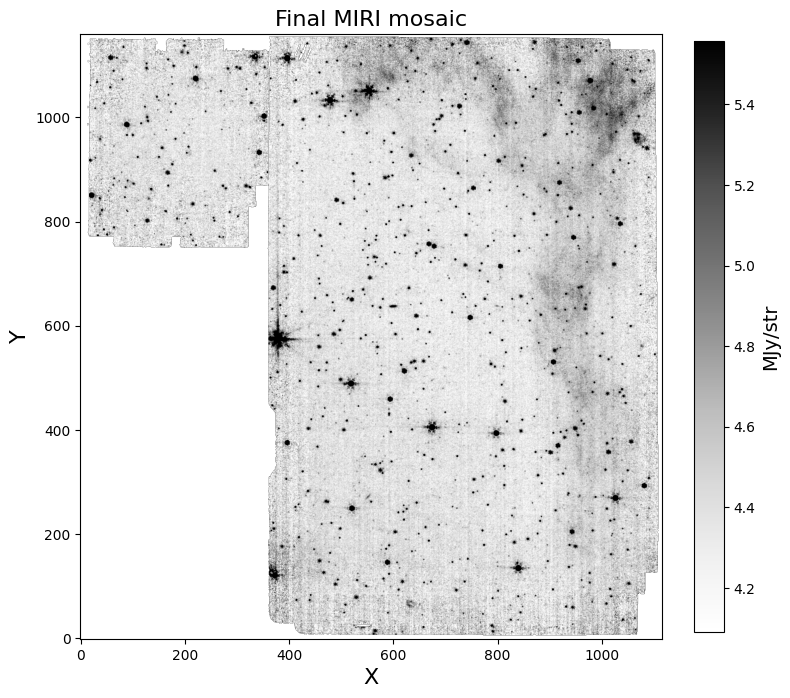

In [34]:
if doviz:
    # Look at the final i2d image (combined mosaic)
    sstring = os.path.join(image3_dir, '*i2d.fits')
    miri_mosaic_file = glob.glob(sstring)
    print(miri_mosaic_file)

    # Read your mosaic image into an ImageModel datamodel
    miri_mosaic = ImageModel(miri_mosaic_file[0])
    
    # Autoscale the stretch
    display_vals = [np.nanpercentile(miri_mosaic.data, 1), np.nanpercentile(miri_mosaic.data, 99)]

    plt.figure(figsize=(8, 8))

    fig, ax = plt.subplots(figsize=(8, 8))

    # Set up image
    cax = ax.imshow(miri_mosaic.data, cmap='Greys', origin='lower', vmin=display_vals[0], vmax=display_vals[1])

    # Set up colorbar
    cb = fig.colorbar(cax, fraction=0.046)
    cb.ax.set_ylabel('MJy/str', fontsize=14)

    # Set labels 
    ax.set_xlabel('X', fontsize=16)
    ax.set_ylabel('Y', fontsize=16)
    ax.set_title('Final MIRI mosaic', fontsize=16)
    plt.tight_layout()

In [35]:
display_vals

[np.float32(4.089625), np.float32(5.5585766)]

## <a id='detections'>Visualize Detected Sources</a>
Using the source catalog created by the `IMAGE3` stage of the pipeline,
mark the detected sources, using different markers for point sources
and extended sources. The source catalog is saved in
`image3/image3_association_cat.ecsv` file. 

### Read in catalog file and identify point/extended sources

In [36]:
if doviz:
    catalog_file = glob.glob(os.path.join(image3_dir, "*_cat.ecsv"))[0]
    catalog = Table.read(catalog_file)

    # find where sources are considered extended or point sources
    pt_src, = np.where(~catalog['is_extended'])
    ext_src, = np.where(catalog['is_extended'])

    # Get x and y coordinates of the objects found 
    miri_x = catalog['xcentroid'][pt_src]
    miri_y = catalog['ycentroid'][pt_src]

    ext_x = catalog['xcentroid'][ext_src]
    ext_y = catalog['ycentroid'][ext_src]

    # Show catalog
    catalog

label,xcentroid,ycentroid,sky_centroid,aper_bkg_flux,aper_bkg_flux_err,aper30_flux,aper30_flux_err,aper50_flux,aper50_flux_err,aper70_flux,aper70_flux_err,aper_total_flux,aper_total_flux_err,aper30_abmag,aper30_abmag_err,aper50_abmag,aper50_abmag_err,aper70_abmag,aper70_abmag_err,aper_total_abmag,aper_total_abmag_err,aper30_vegamag,aper30_vegamag_err,aper50_vegamag,aper50_vegamag_err,aper70_vegamag,aper70_vegamag_err,aper_total_vegamag,aper_total_vegamag_err,CI_50_30,CI_70_50,CI_70_30,is_extended,sharpness,roundness,nn_label,nn_dist,isophotal_flux,isophotal_flux_err,isophotal_abmag,isophotal_abmag_err,isophotal_vegamag,isophotal_vegamag_err,isophotal_area,semimajor_sigma,semiminor_sigma,ellipticity,orientation,sky_orientation,sky_bbox_ll,sky_bbox_ul,sky_bbox_lr,sky_bbox_ur
,,,"deg,deg",Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,,,,,,,,,,,,,,,,,,,,,,,,pix,Jy,Jy,,,,,pix2,pix,pix,,deg,deg,"deg,deg","deg,deg","deg,deg","deg,deg"
int32,float64,float64,SkyCoord,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float32,int32,float64,float64,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,SkyCoord,SkyCoord,SkyCoord,SkyCoord
1,565.2549,14.4137,"80.56165735947239,-69.43590915581524",2.135599e-08,5.627136e-09,1.477625e-05,2.609391e-07,2.869221e-05,3.854329e-07,4.774304e-05,6.700192e-07,6.885998e-05,9.663716e-07,20.976089,0.019006,20.255590,0.014488,19.702725,0.015131,19.305083,0.015131,16.592109,0.019006,15.871610,0.014488,15.318745,0.015131,14.921103,0.015131,1.9418,1.6640,3.2311,False,0.226591,1.603836,7,24.667159,6.061346e-05,8.536932e-07,19.443577,0.015185,15.059597,0.015185,96.0,2.955318,1.650560,0.441495,62.906187,320.862340,"80.56103723043908,-69.43573779668367","80.56127498171776,-69.4361295234562","80.56206665354586,-69.43566070706972","80.56230442273437,-69.4360524324372"
2,605.1704,8.7669,"80.56497821428461,-69.43548254664304",3.034837e-08,7.038789e-09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,5,13.644258,2.050962e-06,2.268761e-07,23.120106,0.113913,18.736126,0.113913,8.0,0.808785,0.687845,0.149534,45.430000,303.386153,"80.56481174572897,-69.43545510502864","80.5648849192506,-69.43557563479227","80.56515487855927,-69.43542940173224","80.56522805391762,-69.43554993135173"
3,1066.5938,10.7844,"80.60459221557207,-69.43257380940443",4.756915e-08,7.975070e-09,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,False,nan,nan,6,6.947139,7.933763e-07,1.833290e-07,24.151302,0.225711,19.767322,0.225711,5.0,0.779008,0.443822,0.430272,70.823373,328.779526,"80.60447484843624,-69.43254216271937","80.60454823441864,-69.43266267579226","80.60473212762793,-69.43252282672651","80.60480551498671,-69.43264333969091"
4,791.4352,14.1301,"80.58105397139425,-69.43444650532162",1.791873e-08,5.753170e-09,5.471495e-06,2.166655e-07,9.136369e-06,3.236250e-07,1.350058e-05,6.067353e-07,1.947195e-05,8.750970e-07,22.054735,0.042165,21.498066,0.037793,21.074119,0.047730,20.676477,0.047730,17.670755,0.042165,17.114086,0.037793,16.690139,0.047730,16.292497,0.047730,1.6698,1.4777,2.4674,False,0.612833,-0.138018,9,10.922342,1.264074e-05,4.831865e-07,21.145569,0.040728,16.761589,0.040728,34.0,1.440662,1.319030,0.084428,-55.789108,202.167045,"80.58073572382544,-69.43435601274635","80.58088224279138,-69.43459705885498","80.58133614168793,-69.43431097665017","80.58148266708021,-69.43455202225364"
5,617.9026,13.6718,"80.56616015379018,-69.43554852263067",2.024294e-08,5.633569e-09,1.205345e-06,1.924078e-07,2.365828e-06,2.961119e-07,4.359931e-06,5.894469e-07,6.288347e-06,8.501617e-07,23.697222,0.160798,22.965042,0.128038,22.301301,0.137677,21.903659,0.137677,19.313242,0.160798,18.581062,0.128038,17.917321,0.137677,17.51

### Mark the extended and point sources on the image

Display combined image with point sources marked with red dots and extended sources marked with blue triangles. You will see that there are a grouping of sources near the top edge of the MIRI image, several of which may be spurious sources, which tend to be found near image edges.

Text(0, 0.5, 'MJy/str')

Text(0.5, 0, 'X')

Text(0, 0.5, 'Y')

Text(0.5, 1.0, 'Final MIRI mosaic')

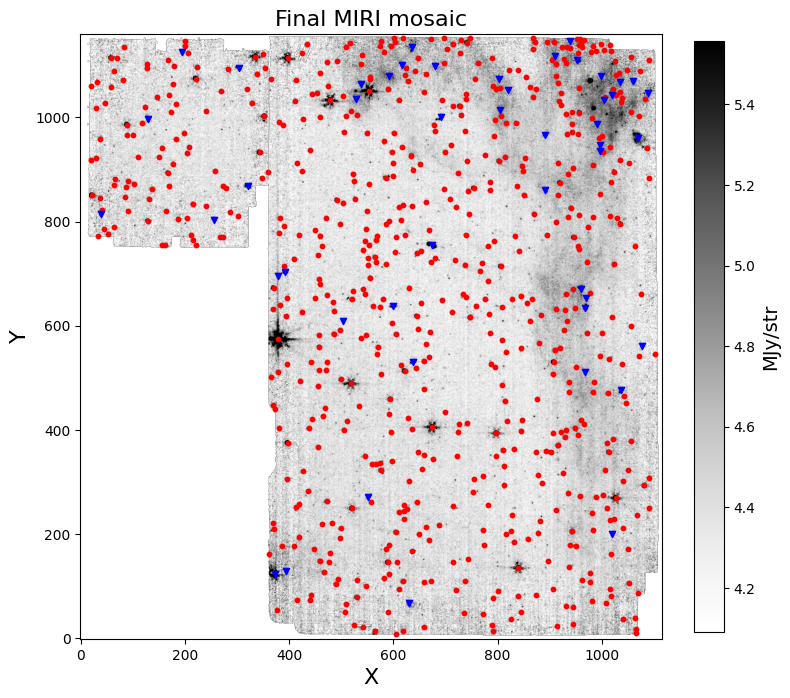

In [37]:
if doviz:
    # Look at mosaic data and sources found with source_catalog
    fig, ax = plt.subplots(figsize=(8, 8))

    # Set up image
    cax = ax.imshow(miri_mosaic.data, cmap='Greys', origin='lower', vmin=display_vals[0], vmax=display_vals[1])
    ax.scatter(miri_x, miri_y, lw=1, s=10, color='red')  # overplot point source positions
    ax.scatter(ext_x, ext_y, lw=1, s=20, color='blue', marker='v')  # overplot extended source positions

    # Set up colorbar
    cb = fig.colorbar(cax, fraction=0.046)
    cb.ax.set_ylabel('MJy/str', fontsize=14)

    # Set labels
    ax.set_xlabel('X', fontsize=16)
    ax.set_ylabel('Y', fontsize=16)
    ax.set_title('Final MIRI mosaic', fontsize=16)
    plt.tight_layout()

<hr style="border:1px solid gray"> </hr>

<img style="float: center;" src="https://github.com/spacetelescope/jwst-pipeline-notebooks/raw/main/_static/stsci_footer.png" alt="stsci_logo" width="200px"/> 